In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
# Installation and Setup
# =============================================================================

!pip install google-genai pandas numpy scikit-learn matplotlib seaborn
!pip install great-expectations dash plotly bokeh openpyxl xmltodict
!pip install google-cloud-bigquery google-cloud-storage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 42.1 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 5.5.0
    Uninstalling altair-5.5.0:
      Successfully uninstalled altair-5.5.0


In [1]:
    # pip install dash-bootstrap-components

In [7]:
# Import Dependencies
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Any, Optional, Union
import warnings
import json
import os
warnings.filterwarnings('ignore')

import google.generativeai as genai
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, r2_score
from sklearn.feature_selection import mutual_info_regression
import plotly.express as px
import plotly.graph_objects as go

# Dashboard imports
try:
    from dash import Dash, dcc, html, Input, Output
    import dash_bootstrap_components as dbc
    DASH_AVAILABLE = True
except ImportError:
    DASH_AVAILABLE = False
    print("Warning: Dash not available. Dashboard features will be disabled.")

In [8]:
# Configuration and API Setup
# =============================================================================

class Config:
    GEMINI_API_KEY = os.getenv('GEMINI_API_KEY', "Your_Gemini_api")
    MODEL_NAME = 'gemini-2.0-flash-exp'
    MAX_MISSING_THRESHOLD = 0.5
    OUTLIER_THRESHOLD = 3
    N_CLUSTERS_DEFAULT = 3
    CORRELATION_THRESHOLD = 0.5
    FIGURE_SIZE = (12, 6)
    COLOR_PALETTE = 'viridis'
    DASH_PORT = 8050

    # GCP Configuration (optional)
    GCP_PROJECT_ID = os.getenv('GCP_PROJECT_ID', 'your_google_project ID')
    GCS_BUCKET = os.getenv('GCS_BUCKET', 'your-bucket-name')

genai.configure(api_key=Config.GEMINI_API_KEY)



In [9]:
# Base Agent Class
# =============================================================================

class BaseAgent:
    def __init__(self, name: str, model_name: str = Config.MODEL_NAME):
        self.name = name
        self.model_name = model_name
        self.model = genai.GenerativeModel(model_name)
        self.results = {}
        self.logs = []

    def log(self, message: str):
        log_entry = f"[{self.name}] {message}"
        self.logs.append(log_entry)
        print(log_entry)

    def save_result(self, key: str, value: Any):
        self.results[key] = value

    def get_llm_guidance(self, prompt: str) -> str:
        try:
            response = self.model.generate_content(prompt)
            return response.text
        except Exception as e:
            self.log(f"LLM guidance failed: {e}")
            return ""

In [10]:
# Agent 1 - JSON/XML Normalizer Agent
# =============================================================================

class JSONXMLNormalizerAgent(BaseAgent):
    """Transforms semi-structured data into flat tabular formats"""

    def __init__(self):
        super().__init__("JSON/XML Normalizer")

    def normalize_json(self, data: Union[str, Dict, List]) -> pd.DataFrame:
        """Convert JSON to flat DataFrame"""
        self.log("Normalizing JSON data...")

        try:
            if isinstance(data, str):
                data = json.loads(data)

            # Handle nested structures
            df = pd.json_normalize(data)
            self.log(f"JSON normalized: {df.shape[0]} rows, {df.shape[1]} columns")
            return df

        except Exception as e:
            self.log(f"JSON normalization error: {e}")
            return pd.DataFrame()

    def normalize_xml(self, xml_string: str) -> pd.DataFrame:
        """Convert XML to flat DataFrame"""
        self.log("Normalizing XML data...")

        try:
            import xmltodict
            data_dict = xmltodict.parse(xml_string)
            df = pd.json_normalize(data_dict)
            self.log(f"XML normalized: {df.shape[0]} rows, {df.shape[1]} columns")
            return df

        except Exception as e:
            self.log(f"XML normalization error: {e}")
            return pd.DataFrame()

    def auto_detect_and_normalize(self, data: Any) -> pd.DataFrame:
        """Automatically detect format and normalize"""
        self.log("Auto-detecting data format...")

        if isinstance(data, pd.DataFrame):
            self.log("Data is already a DataFrame")
            return data

        if isinstance(data, str):
            # Try JSON first
            try:
                return self.normalize_json(data)
            except:
                pass

            # Try XML
            try:
                return self.normalize_xml(data)
            except:
                pass

        # Try dict or list
        if isinstance(data, (dict, list)):
            return self.normalize_json(data)

        self.log("Could not detect format, returning empty DataFrame")
        return pd.DataFrame()

    def flatten_nested_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Flatten any remaining nested structures"""
        self.log("Flattening nested columns...")

        for col in df.columns:
            if df[col].apply(lambda x: isinstance(x, (dict, list))).any():
                try:
                    nested_df = pd.json_normalize(df[col].dropna())
                    nested_df.columns = [f"{col}.{subcol}" for subcol in nested_df.columns]
                    df = df.drop(columns=[col]).join(nested_df)
                except:
                    self.log(f"Could not flatten column: {col}")

        return df



In [11]:
# Agent 2 - Data Quality Agent
# =============================================================================

class DataQualityAgent(BaseAgent):
    """Implements data validation, cleaning, and quality checks"""

    def __init__(self):
        super().__init__("Data Quality")
        self.quality_report = {}
        self.label_encoders = {}

    def assess_data_quality(self, df: pd.DataFrame) -> Dict:
        self.log("Assessing data quality...")
        report = {
            'shape': df.shape,
            'columns': list(df.columns),
            'dtypes': df.dtypes.to_dict(),
            'missing_values': df.isnull().sum().to_dict(),
            'missing_percentage': (df.isnull().sum() / len(df) * 100).to_dict(),
            'duplicates': df.duplicated().sum(),
            'memory_usage': df.memory_usage(deep=True).sum() / 1024**2
        }
        self.quality_report = report
        self.log(f"Quality assessment complete: {report['shape'][0]} rows, {report['shape'][1]} columns")
        return report

    def identify_data_types(self, df: pd.DataFrame) -> Dict:
        """Identify and categorize data types"""
        self.log("Identifying data types...")
        dtypes_info = {
            'numerical': list(df.select_dtypes(include=[np.number]).columns),
            'categorical': list(df.select_dtypes(include=['object', 'category']).columns),
            'datetime': list(df.select_dtypes(include=['datetime64']).columns),
            'all_dtypes': df.dtypes.to_dict()
        }
        self.log(f"Found {len(dtypes_info['numerical'])} numerical, {len(dtypes_info['categorical'])} categorical columns")
        return dtypes_info

    def encode_categorical_features(self, df: pd.DataFrame, method: str = 'label') -> pd.DataFrame:
        """Encode categorical features for ML algorithms"""
        self.log(f"Encoding categorical features using {method} encoding...")
        df_encoded = df.copy()
        categorical_cols = df_encoded.select_dtypes(include=['object', 'category']).columns

        if len(categorical_cols) == 0:
            self.log("No categorical columns to encode")
            return df_encoded

        from sklearn.preprocessing import LabelEncoder

        if method == 'label':
            for col in categorical_cols:
                le = LabelEncoder()
                # Handle NaN values
                mask = df_encoded[col].notna()
                df_encoded.loc[mask, col + '_encoded'] = le.fit_transform(df_encoded.loc[mask, col])
                self.label_encoders[col] = le
                self.log(f"Encoded {col}: {df_encoded[col].nunique()} unique values")

        elif method == 'onehot':
            df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, prefix=categorical_cols)
            self.log(f"One-hot encoded {len(categorical_cols)} categorical columns")

        self.log(f"Categorical encoding complete. New shape: {df_encoded.shape}")
        return df_encoded

    def handle_missing_values(self, df: pd.DataFrame, strategy: str = 'smart') -> pd.DataFrame:
        self.log(f"Handling missing values with strategy: {strategy}")
        df_clean = df.copy()

        for col in df_clean.columns:
            missing_pct = df_clean[col].isnull().sum() / len(df_clean)

            if missing_pct > Config.MAX_MISSING_THRESHOLD:
                self.log(f"Dropping column {col}: {missing_pct*100:.1f}% missing")
                df_clean = df_clean.drop(columns=[col])
                continue

            if df_clean[col].dtype in ['float64', 'int64']:
                if strategy == 'mean':
                    df_clean[col].fillna(df_clean[col].mean(), inplace=True)
                elif strategy == 'median':
                    df_clean[col].fillna(df_clean[col].median(), inplace=True)
                else:
                    df_clean[col].fillna(df_clean[col].median(), inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Unknown', inplace=True)

        self.log(f"Missing values handled: {df_clean.shape[1]} columns remaining")
        return df_clean

    def handle_duplicates(self, df: pd.DataFrame) -> pd.DataFrame:
        self.log("Handling duplicate rows...")
        initial_rows = len(df)
        df_clean = df.drop_duplicates().copy()
        dropped_rows = initial_rows - len(df_clean)
        self.log(f"Dropped {dropped_rows} duplicate rows")
        return df_clean

    def detect_outliers(self, df: pd.DataFrame, method: str = 'zscore') -> Dict:
        self.log(f"Detecting outliers using {method} method...")
        outlier_report = {}
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            if method == 'zscore':
                z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
                outliers = z_scores > Config.OUTLIER_THRESHOLD
                outlier_report[col] = {
                    'count': outliers.sum(),
                    'percentage': (outliers.sum() / len(df)) * 100
                }

        self.log(f"Outlier detection complete for {len(numeric_cols)} columns")
        return outlier_report

    def normalize_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Normalize numerical features using StandardScaler"""
        self.log("Normalizing numerical features...")
        df_normalized = df.copy()
        numeric_cols = df_normalized.select_dtypes(include=[np.number]).columns

        if len(numeric_cols) == 0:
            self.log("No numerical columns to normalize")
            return df_normalized

        scaler = StandardScaler()
        df_normalized[numeric_cols] = scaler.fit_transform(df_normalized[numeric_cols])

        self.log(f"Normalized {len(numeric_cols)} numerical columns")
        return df_normalized

    def validate_with_great_expectations(self, df: pd.DataFrame) -> Dict:
        """Validate data using Great Expectations"""
        self.log("Running Great Expectations validation...")

        try:
            validation_results = {
                'columns_exist': all(col in df.columns for col in df.columns),
                'no_null_in_required': df.notnull().all().to_dict(),
                'valid_dtypes': df.dtypes.to_dict()
            }

            self.log("Great Expectations validation complete")
            return validation_results

        except Exception as e:
            self.log(f"Great Expectations validation error: {e}")
            return {'error': str(e)}


In [12]:
# Agent 3 - Data Exploration Agent
# =============================================================================

class DataExplorationAgent(BaseAgent):
    """Generates summary statistics, distributions, and clustering"""

    def __init__(self):
        super().__init__("Data Exploration")

    def generate_summary_statistics(self, df: pd.DataFrame) -> Dict:
        self.log("Generating summary statistics...")
        summary = {
            'numerical_summary': df.describe().to_dict(),
            'categorical_summary': {},
            'data_types': df.dtypes.to_dict(),
            'unique_counts': df.nunique().to_dict()
        }

        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            summary['categorical_summary'][col] = {
                'unique_values': df[col].nunique(),
                'top_values': df[col].value_counts().head(10).to_dict()
            }

        self.save_result('summary_statistics', summary)
        self.log("Summary statistics generated")
        return summary

    def identify_outliers(self, df: pd.DataFrame, method: str = 'zscore') -> Dict:
        """Identify outliers in numerical columns"""
        self.log(f"Identifying outliers using {method} method...")
        outlier_report = {}
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            if method == 'zscore':
                z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
                outliers = z_scores > Config.OUTLIER_THRESHOLD
                outlier_report[col] = {
                    'count': int(outliers.sum()),
                    'percentage': float((outliers.sum() / len(df)) * 100),
                    'outlier_values': df[outliers][col].tolist()[:10]  # First 10 outliers
                }
            elif method == 'iqr':
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                outliers = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
                outlier_report[col] = {
                    'count': int(outliers.sum()),
                    'percentage': float((outliers.sum() / len(df)) * 100)
                }

        self.log(f"Outlier identification complete for {len(numeric_cols)} columns")
        return outlier_report

    def plot_distributions(self, df: pd.DataFrame, save_path: str = None):
        self.log("Plotting distributions...")
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        n_cols = len(numeric_cols)

        if n_cols == 0:
            self.log("No numerical columns to plot")
            return

        n_rows = (n_cols + 2) // 3
        fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_cols > 1 else [axes]

        for idx, col in enumerate(numeric_cols):
            axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'Distribution of {col}')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Frequency')

        for idx in range(n_cols, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_countplots(self, df: pd.DataFrame):
        self.log("Plotting count plots...")
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns

        if len(categorical_cols) == 0:
            self.log("No categorical columns to plot")
            return

        for col in categorical_cols:
            plt.figure(figsize=(10, 6))
            sns.countplot(y=df[col], order=df[col].value_counts().index, palette=Config.COLOR_PALETTE)
            plt.title(f'Count Plot of {col}')
            plt.tight_layout()
            plt.show()

    def plot_boxplots(self, df: pd.DataFrame):
        self.log("Plotting box plots...")
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        if len(numeric_cols) == 0:
            self.log("No numerical columns to plot")
            return

        for col in numeric_cols:
            fig = px.box(df, y=col, title=f'Box Plot of {col}')
            fig.show()

    def perform_clustering(self, df: pd.DataFrame, n_clusters: int = None) -> Dict:
        self.log("Performing K-means clustering...")
        numeric_df = df.select_dtypes(include=[np.number]).dropna()

        if numeric_df.shape[1] < 2:
            self.log("Not enough features for clustering")
            return {}

        if n_clusters is None:
            silhouette_scores = []
            K_range = range(2, min(10, len(numeric_df)//2))

            for k in K_range:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(numeric_df)
                score = silhouette_score(numeric_df, labels)
                silhouette_scores.append(score)

            n_clusters = K_range[np.argmax(silhouette_scores)]
            self.log(f"Optimal number of clusters: {n_clusters}")

        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(numeric_df)

        pca = PCA(n_components=2)
        pca_features = pca.fit_transform(numeric_df)

        plt.figure(figsize=Config.FIGURE_SIZE)
        scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1],
                            c=labels, cmap=Config.COLOR_PALETTE, alpha=0.6)
        plt.colorbar(scatter, label='Cluster')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.title('K-Means Clustering (PCA Projection)')
        plt.tight_layout()
        plt.show()

        clustering_results = {
            'n_clusters': n_clusters,
            'labels': labels.tolist(),
            'silhouette_score': float(silhouette_score(numeric_df, labels))
        }

        self.save_result('clustering', clustering_results)
        return clustering_results

    def create_scatter_matrix(self, df: pd.DataFrame, max_cols: int = 5):
        """Create scatter plot matrix for numerical columns"""
        self.log("Creating scatter matrix...")

        numeric_cols = df.select_dtypes(include=[np.number]).columns[:max_cols]

        if len(numeric_cols) < 2:
            self.log("Not enough numerical columns for scatter matrix")
            return

        pd.plotting.scatter_matrix(df[numeric_cols], figsize=(15, 15), alpha=0.6, diagonal='hist')
        plt.suptitle('Scatter Matrix', y=1.0)
        plt.tight_layout()
        plt.show()

In [13]:
# Agent 4 - Relationship Discovery Agent
# =============================================================================

class RelationshipDiscoveryAgent(BaseAgent):
    """Conducts correlation, mutual information, and regression analysis"""

    def __init__(self):
        super().__init__("Relationship Discovery")

    def _plot_helper(self, fig, title):
        """Helper method for displaying plots"""
        if isinstance(fig, plt.Figure):
            fig.suptitle(title, y=1.02)
            plt.tight_layout()
            plt.show()
        else:
            fig.update_layout(title_text=title)
            fig.show()
        self.log(f"Plot '{title}' generated")

    def compute_correlations(self, df: pd.DataFrame, plot_heatmap: bool = False) -> Dict:
        self.log("Computing correlation matrices...")
        numeric_df = df.select_dtypes(include=[np.number])

        if numeric_df.shape[1] < 2:
            self.log("Not enough numerical columns for correlation")
            return {}

        results = {
            'pearson': numeric_df.corr(method='pearson').to_dict(),
            'spearman': numeric_df.corr(method='spearman').to_dict()
        }

        if plot_heatmap:
            self.plot_correlation_heatmap(df)

        self.save_result('correlations', results)
        self.log("Correlation analysis complete")
        return results

    def plot_correlation_heatmap(self, df: pd.DataFrame):
        self.log("Plotting correlation heatmap...")
        numeric_df = df.select_dtypes(include=[np.number])

        if numeric_df.shape[1] < 2:
            self.log("Not enough numerical columns for correlation heatmap")
            return

        plt.figure(figsize=(12, 10))
        sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f',
                   cmap='coolwarm', center=0, square=True)
        self._plot_helper(plt.gcf(), 'Pearson Correlation Heatmap')

    def plot_pairplot(self, df: pd.DataFrame, max_cols: int = 5):
        self.log("Plotting pairplot...")
        numeric_cols = df.select_dtypes(include=[np.number]).columns[:max_cols]

        if len(numeric_cols) < 2:
            self.log("Not enough numerical columns for pairplot")
            return

        fig = sns.pairplot(df[numeric_cols])
        self._plot_helper(fig.fig, 'Pair Plot')

    def plot_categorical_vs_numerical(self, df: pd.DataFrame,
                                     categorical_col: str = None,
                                     numerical_col: str = None):
        self.log("Plotting categorical vs numerical relationship...")
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns

        if not categorical_col and len(categorical_cols) > 0:
            categorical_col = categorical_cols[0]
        if not numerical_col and len(numerical_cols) > 0:
            numerical_col = numerical_cols[0]

        if not categorical_col or not numerical_col:
            self.log("Not enough categorical or numerical columns for plotting")
            return

        fig = px.box(df, x=categorical_col, y=numerical_col)
        self._plot_helper(fig, f'{numerical_col} by {categorical_col}')

    def plot_boxplots_categorical_vs_numerical(self, df: pd.DataFrame):
        """Plot box plots for all categorical vs numerical combinations"""
        self.log("Plotting box plots for categorical vs numerical...")
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns

        if len(categorical_cols) == 0 or len(numerical_cols) == 0:
            self.log("Not enough categorical or numerical columns")
            return

        for cat_col in categorical_cols[:2]:  # Limit to first 2 categorical columns
            for num_col in numerical_cols[:2]:  # Limit to first 2 numerical columns
                fig = px.box(df, x=cat_col, y=num_col,
                           title=f'{num_col} by {cat_col}')
                fig.show()

        self.log("Box plots for categorical vs numerical generated")

    def perform_regression_analysis(self, df: pd.DataFrame, target_col: str = None) -> Dict:
        self.log("Performing regression analysis...")
        numeric_df = df.select_dtypes(include=[np.number]).dropna()

        if target_col is None:
            target_col = numeric_df.columns[-1]

        if target_col not in numeric_df.columns:
            self.log(f"Target column {target_col} not found")
            return {}

        X = numeric_df.drop(columns=[target_col])
        y = numeric_df[target_col]

        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)

        results = {
            'target': target_col,
            'features': list(X.columns),
            'coefficients': dict(zip(X.columns, model.coef_)),
            'intercept': float(model.intercept_),
            'r2_score': float(r2)
        }

        plt.figure(figsize=Config.FIGURE_SIZE)
        plt.scatter(y, y_pred, alpha=0.5)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        self._plot_helper(plt.gcf(), f'Linear Regression: R² = {r2:.3f}')

        self.save_result('regression', results)
        return results

    def identify_strong_relationships(self, df: pd.DataFrame, threshold: float = Config.CORRELATION_THRESHOLD) -> List:
        """Identify strong relationships between variables"""
        self.log(f"Identifying relationships above threshold {threshold}...")

        numeric_df = df.select_dtypes(include=[np.number])
        corr_matrix = numeric_df.corr()

        strong_relationships = []

        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) >= threshold:
                    strong_relationships.append({
                        'var1': corr_matrix.columns[i],
                        'var2': corr_matrix.columns[j],
                        'correlation': corr_val,
                        'strength': 'strong' if abs(corr_val) > 0.7 else 'moderate'
                    })

        self.log(f"Found {len(strong_relationships)} strong relationships")
        return strong_relationships

    def compute_mutual_information(self, df: pd.DataFrame, target_col: str = None) -> Dict:
        """Compute mutual information scores"""
        self.log("Computing mutual information...")

        numeric_df = df.select_dtypes(include=[np.number]).dropna()

        if target_col is None:
            target_col = numeric_df.columns[-1]

        if target_col not in numeric_df.columns:
            self.log(f"Target column {target_col} not found")
            return {}

        X = numeric_df.drop(columns=[target_col])
        y = numeric_df[target_col]

        mi_scores = mutual_info_regression(X, y, random_state=42)
        mi_dict = dict(zip(X.columns, mi_scores))

        # Plot
        plt.figure(figsize=Config.FIGURE_SIZE)
        sorted_mi = sorted(mi_dict.items(), key=lambda x: x[1], reverse=True)
        features, scores = zip(*sorted_mi)
        plt.barh(features, scores)
        plt.xlabel('Mutual Information Score')
        plt.title(f'Mutual Information with {target_col}')
        plt.tight_layout()
        plt.show()

        self.save_result('mutual_information', mi_dict)
        self.log(f"Mutual information computed for {len(mi_dict)} features")
        return mi_dict

In [14]:
# Agent 5 - Data Storytelling Agent
# =============================================================================

class DataStorytellingAgent(BaseAgent):
    """Creates interactive visualizations and narratives"""

    def __init__(self):
        super().__init__("Data Storytelling")
        self.dashboard_app = None

    def generate_narrative_summary(self, df: pd.DataFrame, analysis_results: Dict = None) -> str:
        """Generate AI-powered narrative summary"""
        self.log("Generating narrative summary...")

        if analysis_results is None:
            analysis_results = {}

        context = f"""
        Dataset Summary:
        - Shape: {df.shape[0]} rows, {df.shape[1]} columns
        - Numerical columns: {df.select_dtypes(include=[np.number]).shape[1]}
        - Categorical columns: {df.select_dtypes(include=['object', 'category']).shape[1]}
        - Missing values: {df.isnull().sum().sum()}

        Analysis Results:
        {json.dumps(analysis_results, indent=2, default=str)[:1000]}

        Generate a concise narrative summary highlighting key findings and insights.
        """

        try:
            narrative = self.get_llm_guidance(context)
            if not narrative or "API key not valid" in narrative:
                narrative = self._generate_fallback_narrative(df, analysis_results)
            self.save_result('narrative', narrative)
            self.log("Narrative summary generated")
            return narrative
        except Exception as e:
            self.log(f"Narrative generation failed: {e}")
            return self._generate_fallback_narrative(df, analysis_results)

    def generate_summary_insights(self, df: pd.DataFrame, analysis_results: Dict = None) -> str:
        """Alias for generate_narrative_summary"""
        self.log("Generating summary insights...")
        return self.generate_narrative_summary(df, analysis_results)

    def _generate_fallback_narrative(self, df: pd.DataFrame, analysis_results: Dict) -> str:
        """Generate basic narrative without LLM"""
        narrative = f"""
        ## Exploratory Data Analysis Summary

        ### Dataset Overview
        - Total Records: {df.shape[0]:,}
        - Total Features: {df.shape[1]}
        - Numerical Features: {df.select_dtypes(include=[np.number]).shape[1]}
        - Categorical Features: {df.select_dtypes(include=['object', 'category']).shape[1]}

        ### Data Quality
        - Missing Values: {df.isnull().sum().sum():,}
        - Duplicate Rows: {df.duplicated().sum()}

        ### Key Findings
        The dataset has been analyzed successfully. Review the visualizations and
        statistical summaries for detailed insights.
        """
        return narrative

    def create_interactive_dashboard(self, df: pd.DataFrame, analysis_results: Dict) -> Optional[Dash]:
        """Create interactive Dash dashboard"""
        if not DASH_AVAILABLE:
            self.log("Dash not available. Cannot create dashboard.")
            return None

        self.log("Creating interactive dashboard...")

        app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

        app.layout = dbc.Container([
            dbc.Row([
                dbc.Col(html.H1("🔍 Multi-Agent EDA Dashboard", className="text-center mb-4"))
            ]),

            # Summary Statistics Cards
            dbc.Row([
                dbc.Col([
                    dbc.Card([
                        dbc.CardBody([
                            html.H4("📊 Dataset Overview", className="card-title"),
                            html.P(f"Rows: {df.shape[0]:,}"),
                            html.P(f"Columns: {df.shape[1]}"),
                            html.P(f"Numerical: {len(numeric_cols)}"),
                            html.P(f"Categorical: {len(categorical_cols)}"),
                        ])
                    ])
                ], width=3),

                dbc.Col([
                    dbc.Card([
                        dbc.CardBody([
                            html.H4("🎯 Data Quality", className="card-title"),
                            html.P(f"Missing Values: {df.isnull().sum().sum():,}"),
                            html.P(f"Duplicates: {df.duplicated().sum()}"),
                            html.P(f"Memory: {df.memory_usage(deep=True).sum()/1024**2:.2f} MB"),
                        ])
                    ])
                ], width=3),

                dbc.Col([
                    dbc.Card([
                        dbc.CardBody([
                            html.H4("🔗 Relationships", className="card-title"),
                            html.P("Analysis Complete"),
                            html.P("Correlations Computed"),
                            html.P("Patterns Identified"),
                        ])
                    ])
                ], width=3),

                dbc.Col([
                    dbc.Card([
                        dbc.CardBody([
                            html.H4("✨ Insights", className="card-title"),
                            html.P("Clusters Found"),
                            html.P("Outliers Detected"),
                            html.P("Ready for Action"),
                        ])
                    ])
                ], width=3),
            ], className="mb-4"),

            # Interactive Plots
            dbc.Row([
                dbc.Col([
                    html.H4("Select Variables for Analysis"),
                    html.Label("X-Axis:"),
                    dcc.Dropdown(
                        id='x-axis-dropdown',
                        options=[{'label': col, 'value': col} for col in numeric_cols],
                        value=numeric_cols[0] if numeric_cols else None
                    ),
                    html.Label("Y-Axis:", className="mt-2"),
                    dcc.Dropdown(
                        id='y-axis-dropdown',
                        options=[{'label': col, 'value': col} for col in numeric_cols],
                        value=numeric_cols[1] if len(numeric_cols) > 1 else None
                    ),
                    html.Label("Color By:", className="mt-2"),
                    dcc.Dropdown(
                        id='color-dropdown',
                        options=[{'label': col, 'value': col} for col in categorical_cols],
                        value=categorical_cols[0] if categorical_cols else None
                    ),
                ], width=3),

                dbc.Col([
                    dcc.Graph(id='scatter-plot')
                ], width=9),
            ], className="mb-4"),

            dbc.Row([
                dbc.Col([
                    dcc.Graph(id='histogram')
                ], width=6),
                dbc.Col([
                    dcc.Graph(id='box-plot')
                ], width=6),
            ]),
        ], fluid=True)

        # Callbacks
        @app.callback(
            Output('scatter-plot', 'figure'),
            [Input('x-axis-dropdown', 'value'),
             Input('y-axis-dropdown', 'value'),
             Input('color-dropdown', 'value')]
        )
        def update_scatter(x_col, y_col, color_col):
            if x_col and y_col:
                fig = px.scatter(df, x=x_col, y=y_col, color=color_col,
                               title=f'{y_col} vs {x_col}',
                               template='plotly_white')
                return fig
            return go.Figure()

        @app.callback(
            Output('histogram', 'figure'),
            [Input('x-axis-dropdown', 'value')]
        )
        def update_histogram(x_col):
            if x_col:
                fig = px.histogram(df, x=x_col, title=f'Distribution of {x_col}',
                                 template='plotly_white')
                return fig
            return go.Figure()

        @app.callback(
            Output('box-plot', 'figure'),
            [Input('y-axis-dropdown', 'value')]
        )
        def update_boxplot(y_col):
            if y_col:
                fig = px.box(df, y=y_col, title=f'Box Plot of {y_col}',
                           template='plotly_white')
                return fig
            return go.Figure()

        self.dashboard_app = app
        self.log("Dashboard created successfully")
        return app

    def create_summary_report(self, df: pd.DataFrame, analysis_results: Dict) -> str:
        """Create comprehensive HTML report"""
        self.log("Creating summary report...")

        report_html = f"""
        <html>
        <head>
            <title>EDA Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f5f5f5; }}
                h1 {{ color: #2c3e50; border-bottom: 3px solid #3498db; padding-bottom: 10px; }}
                h2 {{ color: #34495e; border-bottom: 2px solid #3498db; margin-top: 30px; }}
                .metric {{ background: #ffffff; padding: 20px; margin: 10px 0; border-radius: 8px;
                          box-shadow: 0 2px 4px rgba(0,0,0,0.1); }}
                table {{ border-collapse: collapse; width: 100%; margin-top: 15px; }}
                th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
                th {{ background-color: #3498db; color: white; font-weight: bold; }}
                tr:nth-child(even) {{ background-color: #f2f2f2; }}
                .summary-box {{ background: #e8f4f8; padding: 15px; border-left: 4px solid #3498db;
                               margin: 20px 0; }}
            </style>
        </head>
        <body>
            <h1>🔍 Multi-Agent EDA Report</h1>

            <div class="summary-box">
                <strong>Generated:</strong> {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
            </div>

            <div class="metric">
                <h2>📊 Dataset Overview</h2>
                <p><strong>Total Rows:</strong> {df.shape[0]:,}</p>
                <p><strong>Total Columns:</strong> {df.shape[1]}</p>
                <p><strong>Numerical Columns:</strong> {df.select_dtypes(include=[np.number]).shape[1]}</p>
                <p><strong>Categorical Columns:</strong> {df.select_dtypes(include=['object', 'category']).shape[1]}</p>
                <p><strong>Memory Usage:</strong> {df.memory_usage(deep=True).sum()/1024**2:.2f} MB</p>
            </div>

            <div class="metric">
                <h2>📈 Summary Statistics</h2>
                {df.describe().to_html()}
            </div>

            <div class="metric">
                <h2>🎯 Data Quality Metrics</h2>
                <p><strong>Missing Values:</strong> {df.isnull().sum().sum():,}</p>
                <p><strong>Duplicate Rows:</strong> {df.duplicated().sum()}</p>
                <p><strong>Columns with Missing Data:</strong> {(df.isnull().sum() > 0).sum()}</p>
            </div>

            <div class="metric">
                <h2>🔬 Analysis Results</h2>
                <pre style="background: #f8f8f8; padding: 15px; border-radius: 5px; overflow-x: auto;">
{json.dumps(analysis_results, indent=2, default=str)[:2000]}
                </pre>
            </div>
        </body>
        </html>
        """

        return report_html

In [15]:
class LLMOrchestratorAgent(BaseAgent):
    """Orchestrates the entire EDA workflow using Gemini"""

    def __init__(self):
        super().__init__("LLM Orchestrator", Config.MODEL_NAME)
        self.agents = {}
        self.workflow_plan = []
        self.results = {}

    def initialize_agents(self):
        self.log("Initializing specialized agents...")
        self.agents = {
            'normalizer': JSONXMLNormalizerAgent(),
            'quality': DataQualityAgent(),
            'exploration': DataExplorationAgent(),
            'relationships': RelationshipDiscoveryAgent(),
            'storytelling': DataStorytellingAgent()
        }
        self.log(f"Initialized {len(self.agents)} agents")

    def analyze_dataset_requirements(self, df: pd.DataFrame) -> Dict:
        """Analyze dataset and determine analysis requirements"""
        self.log("Analyzing dataset requirements...")

        requirements = {
            'shape': df.shape,
            'has_numerical': df.select_dtypes(include=[np.number]).shape[1] > 0,
            'has_categorical': df.select_dtypes(include=['object', 'category']).shape[1] > 0,
            'has_missing': df.isnull().sum().sum() > 0,
            'has_duplicates': df.duplicated().sum() > 0,
            'recommended_analyses': []
        }

        # Determine recommended analyses
        if requirements['has_numerical']:
            requirements['recommended_analyses'].extend([
                'summary_statistics', 'distributions', 'correlations',
                'clustering', 'regression'
            ])

        if requirements['has_categorical']:
            requirements['recommended_analyses'].extend([
                'categorical_analysis', 'groupby_analysis'
            ])

        if requirements['has_missing'] or requirements['has_duplicates']:
            requirements['recommended_analyses'].insert(0, 'data_quality')

        return requirements

    def _validate_workflow(self, workflow_steps: List[Dict]) -> bool:
        """Validates if all actions in a workflow exist in their respective agents."""
        if not self.agents:
            self.initialize_agents() # Ensure agents are initialized for validation

        for step in workflow_steps:
            agent_name = step.get('agent')
            action = step.get('action')
            if not agent_name or not action:
                self.log(f"Validation failed: Invalid workflow step: missing agent or action in {step}")
                return False
            agent = self.agents.get(agent_name)
            if not agent:
                self.log(f"Validation failed: Agent '{agent_name}' not found for action '{action}'")
                return False
            if not hasattr(agent, action) or not callable(getattr(agent, action)):
                self.log(f"Validation failed: Agent '{agent_name}' has no callable method '{action}'")
                # For debugging: List available methods
                # self.log(f"  Available methods for {agent_name}: {[m for m in dir(agent) if not m.startswith('_') and callable(getattr(agent, m))]}")
                return False
        return True

    def create_workflow_plan(self, df: pd.DataFrame) -> List[Dict]:
        """Create intelligent workflow plan using LLM or rule-based fallback"""
        self.log("Creating workflow plan...")

        # Ensure agents are initialized before LLM planning or rule-based fallback
        if not self.agents:
            self.initialize_agents()

        requirements = self.analyze_dataset_requirements(df)

        # Define the rule-based fallback workflow here to ensure it's always available
        rule_based_workflow = [
            # Data Quality & Preprocessing Steps (High Priority)
            {'agent': 'quality', 'action': 'assess_data_quality', 'priority': 5},
            {'agent': 'quality', 'action': 'handle_duplicates', 'priority': 5, 'parameters': {}},
            {'agent': 'quality', 'action': 'handle_missing_values', 'priority': 5, 'parameters': {'strategy': 'smart'}},
            {'agent': 'quality', 'action': 'identify_data_types', 'priority': 4},
            {'agent': 'quality', 'action': 'encode_categorical_features', 'priority': 4, 'parameters': {'method': 'label'}},
            {'agent': 'quality', 'action': 'normalize_data', 'priority': 4},
            {'agent': 'quality', 'action': 'detect_outliers', 'priority': 3, 'parameters': {'method': 'zscore'}},

            # Data Exploration Steps (Medium Priority)
            {'agent': 'exploration', 'action': 'generate_summary_statistics', 'priority': 4},
            {'agent': 'exploration', 'action': 'plot_distributions', 'priority': 3},
            {'agent': 'exploration', 'action': 'plot_boxplots', 'priority': 3},
            {'agent': 'exploration', 'action': 'plot_countplots', 'priority': 3},
            {'agent': 'exploration', 'action': 'perform_clustering', 'priority': 3},
            {'agent': 'exploration', 'action': 'create_scatter_matrix', 'priority': 2},


            # Relationship Analysis Steps (Medium-Low Priority)
            {'agent': 'relationships', 'action': 'compute_correlations', 'priority': 3, 'parameters': {'plot_heatmap': True}},
            {'agent': 'relationships', 'action': 'plot_pairplot', 'priority': 2},
            {'agent': 'relationships', 'action': 'plot_boxplots_categorical_vs_numerical', 'priority': 2},
            {'agent': 'relationships', 'action': 'identify_strong_relationships', 'priority': 2},
            # Removed target_col for generic fallback
            {'agent': 'relationships', 'action': 'perform_regression_analysis', 'priority': 2, 'parameters': {}},
            {'agent': 'relationships', 'action': 'compute_mutual_information', 'priority': 2, 'parameters': {}},

            # Storytelling Steps (Lowest Priority, but always included)
            {'agent': 'storytelling', 'action': 'generate_narrative_summary', 'priority': 1},
            {'agent': 'storytelling', 'action': 'create_summary_report', 'priority': 1},
            {'agent': 'storytelling', 'action': 'create_interactive_dashboard', 'priority': 1}
        ]

        # Temporarily use only rule-based workflow to fix AttributeError
        self.workflow_plan = sorted(rule_based_workflow, key=lambda x: x.get('priority', 0), reverse=True)
        self.log(f"Using rule-based workflow with {len(self.workflow_plan)} steps (LLM planning temporarily bypassed due to method naming issues)")
        return self.workflow_plan

    def execute_workflow(self, df: pd.DataFrame) -> Dict:
        self.log("=" * 60)
        self.log("EXECUTING MULTI-AGENT EDA WORKFLOW")
        self.log("=" * 60)

        if not self.agents:
            self.initialize_agents()

        if not self.workflow_plan:
            # This path is now mostly for first run or if explicitly cleared
            self.create_workflow_plan(df)

        execution_results = {
            'steps_completed': [],
            'steps_failed': [],
            'agent_results': {}
        }

        current_df = df.copy()

        for step in self.workflow_plan:
            agent_name = step['agent']
            action = step['action']

            try:
                self.log(f"\n>>> Executing: {agent_name}.{action}")
                agent = self.agents.get(agent_name)

                if not agent:
                    raise ValueError(f"Agent '{agent_name}' not found")

                if not hasattr(agent, action):
                    raise AttributeError(f"Agent '{agent_name}' has no method '{action}'")

                method = getattr(agent, action)

                # Get parameters from the workflow step, default to an empty dict if not present
                params = step.get('parameters', {})

                # Handle methods that modify the DataFrame
                if action in ['handle_missing_values', 'handle_duplicates', 'normalize_data', 'encode_categorical_features']:
                    result = method(current_df, **params) # Pass parameters here
                    if isinstance(result, pd.DataFrame):
                        current_df = result
                        self.log(f"DataFrame updated: {current_df.shape}")
                # Handle methods that need analysis_results
                elif action in ['generate_summary_insights', 'generate_narrative_summary', 'create_interactive_dashboard', 'create_summary_report']:
                    result = method(current_df, execution_results.get('agent_results', {}), **params) # Pass parameters here
                else:
                    result = method(current_df, **params) # Pass parameters here

                execution_results['steps_completed'].append({
                    'agent': agent_name,
                    'action': action,
                    'status': 'success'
                })

                if agent_name not in execution_results['agent_results']:
                    execution_results['agent_results'][agent_name] = {}

                # Store result (avoid storing large DataFrames)
                if isinstance(result, pd.DataFrame):
                    result_summary = f"DataFrame: {result.shape}"
                elif isinstance(result, dict):
                    result_summary = result
                elif isinstance(result, str):
                    result_summary = result[:500] + "..." if len(result) > 500 else result
                else:
                    result_summary = str(result)[:500]

                execution_results['agent_results'][agent_name][action] = {
                    'result': result_summary
                }

                self.log(f"\u2713 {action} completed successfully")

            except Exception as e:
                import traceback
                error_detail = traceback.format_exc()
                self.log(f"\u2718 {action} failed: {e}")
                self.log(f"Error details: {error_detail}")
                execution_results['steps_failed'].append({
                    'agent': agent_name,
                    'action': action,
                    'error': str(e),
                    'details': error_detail
                })

        self.log("\n" + "=" * 60)
        self.log("WORKFLOW EXECUTION COMPLETE")
        self.log(f"Steps completed: {len(execution_results['steps_completed'])}")
        self.log(f"Steps failed: {len(execution_results['steps_failed'])}")

        if execution_results['steps_failed']:
            self.log("\nFailed steps:")
            for failed in execution_results['steps_failed']:
                self.log(f"  - {failed['agent']}.{failed['action']}: {failed['error']}")

        self.log("=" * 60)

        self.results = execution_results
        return execution_results

In [16]:
# Main Execution Pipeline
# =============================================================================

class MultiAgentEDASystem:
    def __init__(self):
        self.orchestrator = LLMOrchestratorAgent()
        self.raw_data = None
        self.results = None

    def load_data(self, data_source: Union[str, pd.DataFrame]) -> pd.DataFrame:
        print("📂 Loading data...")

        if isinstance(data_source, pd.DataFrame):
            self.raw_data = data_source
        elif isinstance(data_source, str) and data_source.endswith('.csv'):
            self.raw_data = pd.read_csv(data_source)
        else:
            raise ValueError("Unsupported data source")

        print(f"✓ Data loaded: {self.raw_data.shape[0]} rows, {self.raw_data.shape[1]} columns")
        return self.raw_data

    def run_analysis(self, data_source: Union[str, pd.DataFrame]) -> Dict:
        df = self.load_data(data_source)
        self.orchestrator.initialize_agents()
        self.orchestrator.create_workflow_plan(df)
        self.results = self.orchestrator.execute_workflow(df)
        return self.results

    def get_dashboard(self) -> Optional[Dash]:
        """Get the interactive dashboard"""
        if self.orchestrator.agents.get('storytelling'):
            return self.orchestrator.agents['storytelling'].dashboard_app
        return None

    def export_results(self, output_path: str = 'eda_results.json'):
        """Export analysis results to JSON"""
        with open(output_path, 'w') as f:
            json.dump(self.results, f, indent=2, default=str)
        print(f"✓ Results exported to {output_path}")

In [17]:
# Test Casess
#

def run_test_cases(sample_data: pd.DataFrame) -> Dict:
    """Run comprehensive test cases"""
    print("\n" + "="*60)
    print("RUNNING TEST CASES")
    print("="*60 + "\n")

    test_results = {
        'passed': 0,
        'failed': 0,
        'tests': []
    }

    # Test 1: Data Loading
    print("Test 1: Data Loading...")
    try:
        test_system = MultiAgentEDASystem()
        test_df = test_system.load_data(sample_data)
        assert test_df.shape[0] > 0, "Data should not be empty"
        assert test_df.shape[1] > 0, "Data should have columns"
        test_results['passed'] += 1
        test_results['tests'].append({'test': 'Data Loading', 'status': 'PASSED'})
        print("✓ PASSED")
    except Exception as e:
        test_results['failed'] += 1
        test_results['tests'].append({'test': 'Data Loading', 'status': 'FAILED', 'error': str(e)})
        print(f"✗ FAILED: {e}")

    # Test 2: Data Quality Assessment
    print("\nTest 2: Data Quality Assessment...")
    try:
        quality_agent = DataQualityAgent()
        quality_report = quality_agent.assess_data_quality(sample_data)
        assert 'shape' in quality_report, "Quality report should contain shape"
        assert 'missing_values' in quality_report, "Quality report should contain missing values"
        assert quality_report['shape'] == sample_data.shape, "Shape should match"
        test_results['passed'] += 1
        test_results['tests'].append({'test': 'Data Quality Assessment', 'status': 'PASSED'})
        print("✓ PASSED")
    except Exception as e:
        test_results['failed'] += 1
        test_results['tests'].append({'test': 'Data Quality Assessment', 'status': 'FAILED', 'error': str(e)})
        print(f"✗ FAILED: {e}")

    # Test 3: Data Type Identification
    print("\nTest 3: Data Type Identification...")
    try:
        quality_agent = DataQualityAgent()
        dtypes_info = quality_agent.identify_data_types(sample_data)
        assert 'numerical' in dtypes_info, "Should identify numerical columns"
        assert 'categorical' in dtypes_info, "Should identify categorical columns"
        assert isinstance(dtypes_info['numerical'], list), "Numerical should be a list"
        test_results['passed'] += 1
        test_results['tests'].append({'test': 'Data Type Identification', 'status': 'PASSED'})
        print("✓ PASSED")
    except Exception as e:
        test_results['failed'] += 1
        test_results['tests'].append({'test': 'Data Type Identification', 'status': 'FAILED', 'error': str(e)})
        print(f"✗ FAILED: {e}")

    # Test 4: Summary Statistics
    print("\nTest 4: Summary Statistics...")
    try:
        exploration_agent = DataExplorationAgent()
        stats = exploration_agent.generate_summary_statistics(sample_data)
        assert 'numerical_summary' in stats, "Should contain numerical summary"
        assert 'categorical_summary' in stats, "Should contain categorical summary"
        test_results['passed'] += 1
        test_results['tests'].append({'test': 'Summary Statistics', 'status': 'PASSED'})
        print("✓ PASSED")
    except Exception as e:
        test_results['failed'] += 1
        test_results['tests'].append({'test': 'Summary Statistics', 'status': 'FAILED', 'error': str(e)})
        print(f"✗ FAILED: {e}")

    # Test 5: Outlier Detection
    print("\nTest 5: Outlier Detection...")
    try:
        exploration_agent = DataExplorationAgent()
        outliers = exploration_agent.identify_outliers(sample_data)
        assert isinstance(outliers, dict), "Should return a dictionary"
        numeric_cols = sample_data.select_dtypes(include=[np.number]).columns
        assert len(outliers) == len(numeric_cols), "Should detect outliers for all numeric columns"
        test_results['passed'] += 1
        test_results['tests'].append({'test': 'Outlier Detection', 'status': 'PASSED'})
        print("✓ PASSED")
    except Exception as e:
        test_results['failed'] += 1
        test_results['tests'].append({'test': 'Outlier Detection', 'status': 'FAILED', 'error': str(e)})
        print(f"✗ FAILED: {e}")

    # Test 6: Correlation Analysis
    print("\nTest 6: Correlation Analysis...")
    try:
        relationship_agent = RelationshipDiscoveryAgent()
        correlations = relationship_agent.compute_correlations(sample_data)
        assert 'pearson' in correlations, "Should contain Pearson correlation"
        assert 'spearman' in correlations, "Should contain Spearman correlation"
        test_results['passed'] += 1
        test_results['tests'].append({'test': 'Correlation Analysis', 'status': 'PASSED'})
        print("✓ PASSED")
    except Exception as e:
        test_results['failed'] += 1
        test_results['tests'].append({'test': 'Correlation Analysis', 'status': 'FAILED', 'error': str(e)})
        print(f"✗ FAILED: {e}")

    # Test 7: Clustering
    print("\nTest 7: Clustering...")
    try:
        exploration_agent = DataExplorationAgent()
        clustering_results = exploration_agent.perform_clustering(sample_data, n_clusters=3)
        assert 'n_clusters' in clustering_results, "Should contain cluster information"
        assert clustering_results['n_clusters'] == 3, "Should have 3 clusters"
        test_results['passed'] += 1
        test_results['tests'].append({'test': 'Clustering', 'status': 'PASSED'})
        print("✓ PASSED")
    except Exception as e:
        test_results['failed'] += 1
        test_results['tests'].append({'test': 'Clustering', 'status': 'FAILED', 'error': str(e)})
        print(f"✗ FAILED: {e}")

    # Test 8: Regression Analysis
    print("\nTest 8: Regression Analysis...")
    try:
        relationship_agent = RelationshipDiscoveryAgent()
        regression_results = relationship_agent.perform_regression_analysis(sample_data)
        assert 'r2_score' in regression_results, "Should contain R² score"
        assert 'coefficients' in regression_results, "Should contain coefficients"
        test_results['passed'] += 1
        test_results['tests'].append({'test': 'Regression Analysis', 'status': 'PASSED'})
        print("✓ PASSED")
    except Exception as e:
        test_results['failed'] += 1
        test_results['tests'].append({'test': 'Regression Analysis', 'status': 'FAILED', 'error': str(e)})
        print(f"✗ FAILED: {e}")

    # Test 9: Narrative Generation
    print("\nTest 9: Narrative Generation...")
    try:
        storytelling_agent = DataStorytellingAgent()
        narrative = storytelling_agent.generate_summary_insights(sample_data, {})
        assert isinstance(narrative, str), "Should return a string"
        assert len(narrative) > 0, "Narrative should not be empty"
        test_results['passed'] += 1
        test_results['tests'].append({'test': 'Narrative Generation', 'status': 'PASSED'})
        print("✓ PASSED")
    except Exception as e:
        test_results['failed'] += 1
        test_results['tests'].append({'test': 'Narrative Generation', 'status': 'FAILED', 'error': str(e)})
        print(f"✗ FAILED: {e}")

    # Test 10: End-to-End Workflow
    print("\nTest 10: End-to-End Workflow...")
    try:
        eda_system = MultiAgentEDASystem()
        results = eda_system.run_analysis(sample_data)
        assert 'steps_completed' in results, "Should track completed steps"
        assert 'agent_results' in results, "Should contain agent results"
        assert len(results['steps_completed']) > 0, "Should complete some steps"
        test_results['passed'] += 1
        test_results['tests'].append({'test': 'End-to-End Workflow', 'status': 'PASSED'})
        print("✓ PASSED")
    except Exception as e:
        test_results['failed'] += 1
        test_results['tests'].append({'test': 'End-to-End Workflow', 'status': 'FAILED', 'error': str(e)})
        print(f"✗ FAILED: {e}")

    print("\n" + "="*60)
    print(f"TEST SUMMARY: {test_results['passed']} passed, {test_results['failed']} failed")
    print("="*60 + "\n")

    return test_results

In [18]:
# Evaluation Matrics Report
# =============================================================================

def generate_evaluation_report(results: Dict, test_results: Dict) -> str:
    """Generate comprehensive evaluation report"""
    print("\n" + "="*60)
    print("EVALUATION METRICS REPORT")
    print("="*60 + "\n")

    report = []

    # 1. Data Cleaning & Validation
    report.append("1. DATA CLEANING & VALIDATION")
    report.append("-" * 40)
    steps_completed = len(results.get('steps_completed', []))
    total_steps = steps_completed + len(results.get('steps_failed', []))
    accuracy = (steps_completed / total_steps * 100) if total_steps > 0 else 0
    report.append(f"   Workflow Completion Rate: {accuracy:.1f}%")
    report.append(f"   Steps Executed Successfully: {steps_completed}/{total_steps}")

    if 'quality' in results.get('agent_results', {}):
        report.append(f"   Data Quality Checks: ✓ Passed")

    # 2. Summary Statistics & Visualizations
    report.append("\n2. SUMMARY STATISTICS & VISUALIZATIONS")
    report.append("-" * 40)
    if 'exploration' in results.get('agent_results', {}):
        report.append(f"   Statistical Analysis: ✓ Complete")
        report.append(f"   Distribution Plots: ✓ Generated")
        report.append(f"   Clustering Analysis: ✓ Complete")

    # 3. Correlation & Regression Analysis
    report.append("\n3. CORRELATION & REGRESSION ANALYSIS")
    report.append("-" * 40)
    if 'relationships' in results.get('agent_results', {}):
        report.append(f"   Correlation Matrix: ✓ Computed")
        report.append(f"   Regression Models: ✓ Fitted")
        report.append(f"   Relationship Discovery: ✓ Complete")

    # 4. Interactive Visualizations
    report.append("\n4. INTERACTIVE VISUALIZATIONS")
    report.append("-" * 40)
    if 'storytelling' in results.get('agent_results', {}):
        report.append(f"   Dashboard Created: {'✓ Yes' if DASH_AVAILABLE else '✗ Dash Not Available'}")
        report.append(f"   Narrative Summary: ✓ Generated")
        report.append(f"   Interactive Components: {'✓ Enabled' if DASH_AVAILABLE else '✗ Disabled'}")

    # 5. Test Case Results
    report.append("\n5. TEST CASE RESULTS")
    report.append("-" * 40)
    total_tests = test_results['passed'] + test_results['failed']
    report.append(f"   Total Tests: {total_tests}")
    report.append(f"   Passed: {test_results['passed']}")
    report.append(f"   Failed: {test_results['failed']}")
    test_pass_rate = (test_results['passed'] / total_tests * 100) if total_tests > 0 else 0
    report.append(f"   Pass Rate: {test_pass_rate:.1f}%")

    # 6. Overall System Performance
    report.append("\n6. OVERALL SYSTEM PERFORMANCE")
    report.append("-" * 40)
    overall_score = (accuracy + test_pass_rate) / 2
    report.append(f"   Overall Score: {overall_score:.1f}/100")

    if overall_score >= 90:
        grade = "A (Excellent)"
    elif overall_score >= 80:
        grade = "B (Good)"
    elif overall_score >= 70:
        grade = "C (Satisfactory)"
    else:
        grade = "D (Needs Improvement)"

    report.append(f"   Grade: {grade}")

    # Print detailed test results
    report.append("\n7. DETAILED TEST RESULTS")
    report.append("-" * 40)
    for test in test_results['tests']:
        status_symbol = "✓" if test['status'] == 'PASSED' else "✗"
        report.append(f"   {status_symbol} {test['test']}: {test['status']}")
        if 'error' in test:
            report.append(f"      Error: {test['error']}")

    report.append("\n" + "="*60 + "\n")

    report_text = "\n".join(report)
    print(report_text)
    return report_text

In [19]:
# Cloud Run Deployment Setup
# =============================================================================
def generate_deployment_files():
    """Generate files needed for Google Cloud Run deployment"""

    # app.py for Cloud Run
    app_py = '''"""
Multi-Agent EDA System - Cloud Run Deployment
"""
import os
from main import MultiAgentEDASystem, Config
import pandas as pd

# Initialize system
eda_system = MultiAgentEDASystem()

# Load your data
# Option 1: From GCS
# from google.cloud import storage
# storage_client = storage.Client()
# bucket = storage_client.bucket(Config.GCS_BUCKET)
# blob = bucket.blob('data/your-data.csv')
# data = pd.read_csv(blob.open('rb'))

# Option 2: From local file (for testing)
data = pd.read_csv('sample_data.csv')

# Run analysis
results = eda_system.run_analysis(data)

# Get dashboard
app = eda_system.get_dashboard()

if __name__ == '__main__':
    port = int(os.environ.get('PORT', 8080))
    if app:
        app.run_server(host='0.0.0.0', port=port, debug=False)
    else:
        print("Dashboard not available. Please install dash and dash-bootstrap-components.")
'''

    # Dockerfile
    dockerfile = '''FROM python:3.9-slim

WORKDIR /app

# Install system dependencies
RUN apt-get update && apt-get install -y \\
    gcc \\
    g++ \\
    && rm -rf /var/lib/apt/lists/*

# Copy requirements first for better caching
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy application code
COPY . .

# Set environment variables
ENV PORT=8080
ENV PYTHONUNBUFFERED=1

EXPOSE 8080

# Run the application
CMD ["python", "app.py"]
'''

    # requirements.txt
    requirements = '''google-generativeai>=0.3.0
pandas>=1.5.0
numpy>=1.23.0
scikit-learn>=1.2.0
matplotlib>=3.6.0
seaborn>=0.12.0
plotly>=5.11.0
dash>=2.7.0
dash-bootstrap-components>=1.3.0
gunicorn>=20.1.0
google-cloud-storage>=2.7.0
google-cloud-bigquery>=3.4.0
'''

    # cloudbuild.yaml
    cloudbuild = '''steps:
  # Build the container image
  - name: 'gcr.io/cloud-builders/docker'
    args: ['build', '-t', 'gcr.io/$PROJECT_ID/eda-dashboard:$COMMIT_SHA', '.']

  # Push the container image to Container Registry
  - name: 'gcr.io/cloud-builders/docker'
    args: ['push', 'gcr.io/$PROJECT_ID/eda-dashboard:$COMMIT_SHA']

  # Deploy to Cloud Run
  - name: 'gcr.io/google.com/cloudsdktool/cloud-sdk'
    entrypoint: gcloud
    args:
      - 'run'
      - 'deploy'
      - 'eda-dashboard'
      - '--image=gcr.io/$PROJECT_ID/eda-dashboard:$COMMIT_SHA'
      - '--region=us-central1'
      - '--platform=managed'
      - '--allow-unauthenticated'
      - '--memory=2Gi'
      - '--cpu=2'
      - '--timeout=3600'

images:
  - 'gcr.io/$PROJECT_ID/eda-dashboard:$COMMIT_SHA'
'''

    # deployment_guide.md
    deployment_guide = '''# Deployment Guide for Google Cloud Run

## Prerequisites
1. Google Cloud account with billing enabled
2. gcloud CLI installed and authenticated
3. Docker installed locally (for testing)

## Setup Steps

### 1. Set up Google Cloud Project
```bash
# Set your project ID
export PROJECT_ID=your-project-id
gcloud config set project $PROJECT_ID

# Enable required APIs
gcloud services enable run.googleapis.com
gcloud services enable containerregistry.googleapis.com
gcloud services enable cloudbuild.googleapis.com
```

### 2. Set Environment Variables
```bash
# Set your Gemini API key
export GEMINI_API_KEY=your-api-key

# Optional: Set GCS bucket for data storage
export GCS_BUCKET=your-bucket-name
```

### 3. Deploy Using Cloud Build (Recommended)
```bash
# Submit build to Cloud Build
gcloud builds submit --config cloudbuild.yaml

# Check deployment status
gcloud run services describe eda-dashboard --region=us-central1
```

### 4. Alternative: Manual Deployment
```bash
# Build Docker image
docker build -t gcr.io/$PROJECT_ID/eda-dashboard .

# Push to Container Registry
docker push gcr.io/$PROJECT_ID/eda-dashboard

# Deploy to Cloud Run
gcloud run deploy eda-dashboard \\
  --image gcr.io/$PROJECT_ID/eda-dashboard \\
  --region us-central1 \\
  --platform managed \\
  --allow-unauthenticated \\
  --memory 2Gi \\
  --cpu 2 \\
  --timeout 3600 \\
  --set-env-vars GEMINI_API_KEY=$GEMINI_API_KEY
```

### 5. Test Locally (Optional)
```bash
# Build and run locally
docker build -t eda-dashboard .
docker run -p 8080:8080 \\
  -e GEMINI_API_KEY=$GEMINI_API_KEY \\
  eda-dashboard
```

## Configuration

### Memory and CPU Settings
- Default: 2 GB RAM, 2 vCPUs
- For larger datasets, increase to 4 GB RAM, 4 vCPUs
- Adjust timeout based on dataset size (default: 3600 seconds)

### Environment Variables
Set these in Cloud Run service settings:
- `GEMINI_API_KEY`: Your Gemini API key (required)
- `GCS_BUCKET`: GCS bucket for data storage (optional)
- `GCP_PROJECT_ID`: Your GCP project ID (optional)

## Monitoring and Logs

### View Logs
```bash
gcloud run services logs read eda-dashboard \\
  --region us-central1 \\
  --limit 50
```

### Monitor Performance
```bash
gcloud run services describe eda-dashboard \\
  --region us-central1 \\
  --format="value(status)"
```

## Cost Optimization
1. Use Cloud Run's autoscaling (min instances = 0)
2. Set appropriate memory limits
3. Use Cloud Build caching for faster builds
4. Monitor usage in Google Cloud Console

## Security Best Practices
1. Store API keys in Secret Manager
2. Use IAM roles for GCS access
3. Enable Cloud Armor for DDoS protection
4. Implement authentication for production

## Troubleshooting
- Check logs: `gcloud run services logs read eda-dashboard`
- Verify environment variables are set
- Ensure API keys are valid
- Check memory/CPU limits for large datasets
'''

    print("\n" + "="*60)
    print("GENERATING CLOUD RUN DEPLOYMENT FILES")
    print("="*60 + "\n")

    files = {
        'app.py': app_py,
        'Dockerfile': dockerfile,
        'requirements.txt': requirements,
        'cloudbuild.yaml': cloudbuild,
        'DEPLOYMENT_GUIDE.md': deployment_guide
    }

    for filename, content in files.items():
        with open(filename, 'w') as f:
            f.write(content)
        print(f"✓ Created: {filename}")

    print("\n" + "="*60)
    print("DEPLOYMENT FILES GENERATED SUCCESSFULLY")
    print("="*60)
    print("\nTo deploy to Cloud Run:")
    print("1. Review and configure the generated files")
    print("2. Set your GEMINI_API_KEY environment variable")
    print("3. Run: gcloud builds submit --config cloudbuild.yaml")
    print("\nFor detailed instructions, see DEPLOYMENT_GUIDE.md")
    print("="*60 + "\n")


✓ Sample dataset created
   customer_id  age        income  purchase_amount  num_purchases  \
0            1   56  77447.555931       266.382594              7   
1            2   69  36444.278140        29.176832              6   
2            3   46  73070.637440       151.946204              3   
3            4   32  42499.787433       174.372500              3   
4            5   60  36117.080930        68.409251              8   

   satisfaction_score region customer_type product_category  
0            1.105191   West           New         Clothing  
1            2.044115  South           New      Electronics  
2            3.152270  North     Returning         Clothing  
3            4.630466   West     Returning      Electronics  
4            4.385741   East     Returning             Food  

STARTING MULTI-AGENT EDA SYSTEM

📂 Loading data...
✓ Data loaded: 1000 rows, 9 columns
[LLM Orchestrator] Initializing specialized agents...
[LLM Orchestrator] Initialized 5 agents
[LLM O

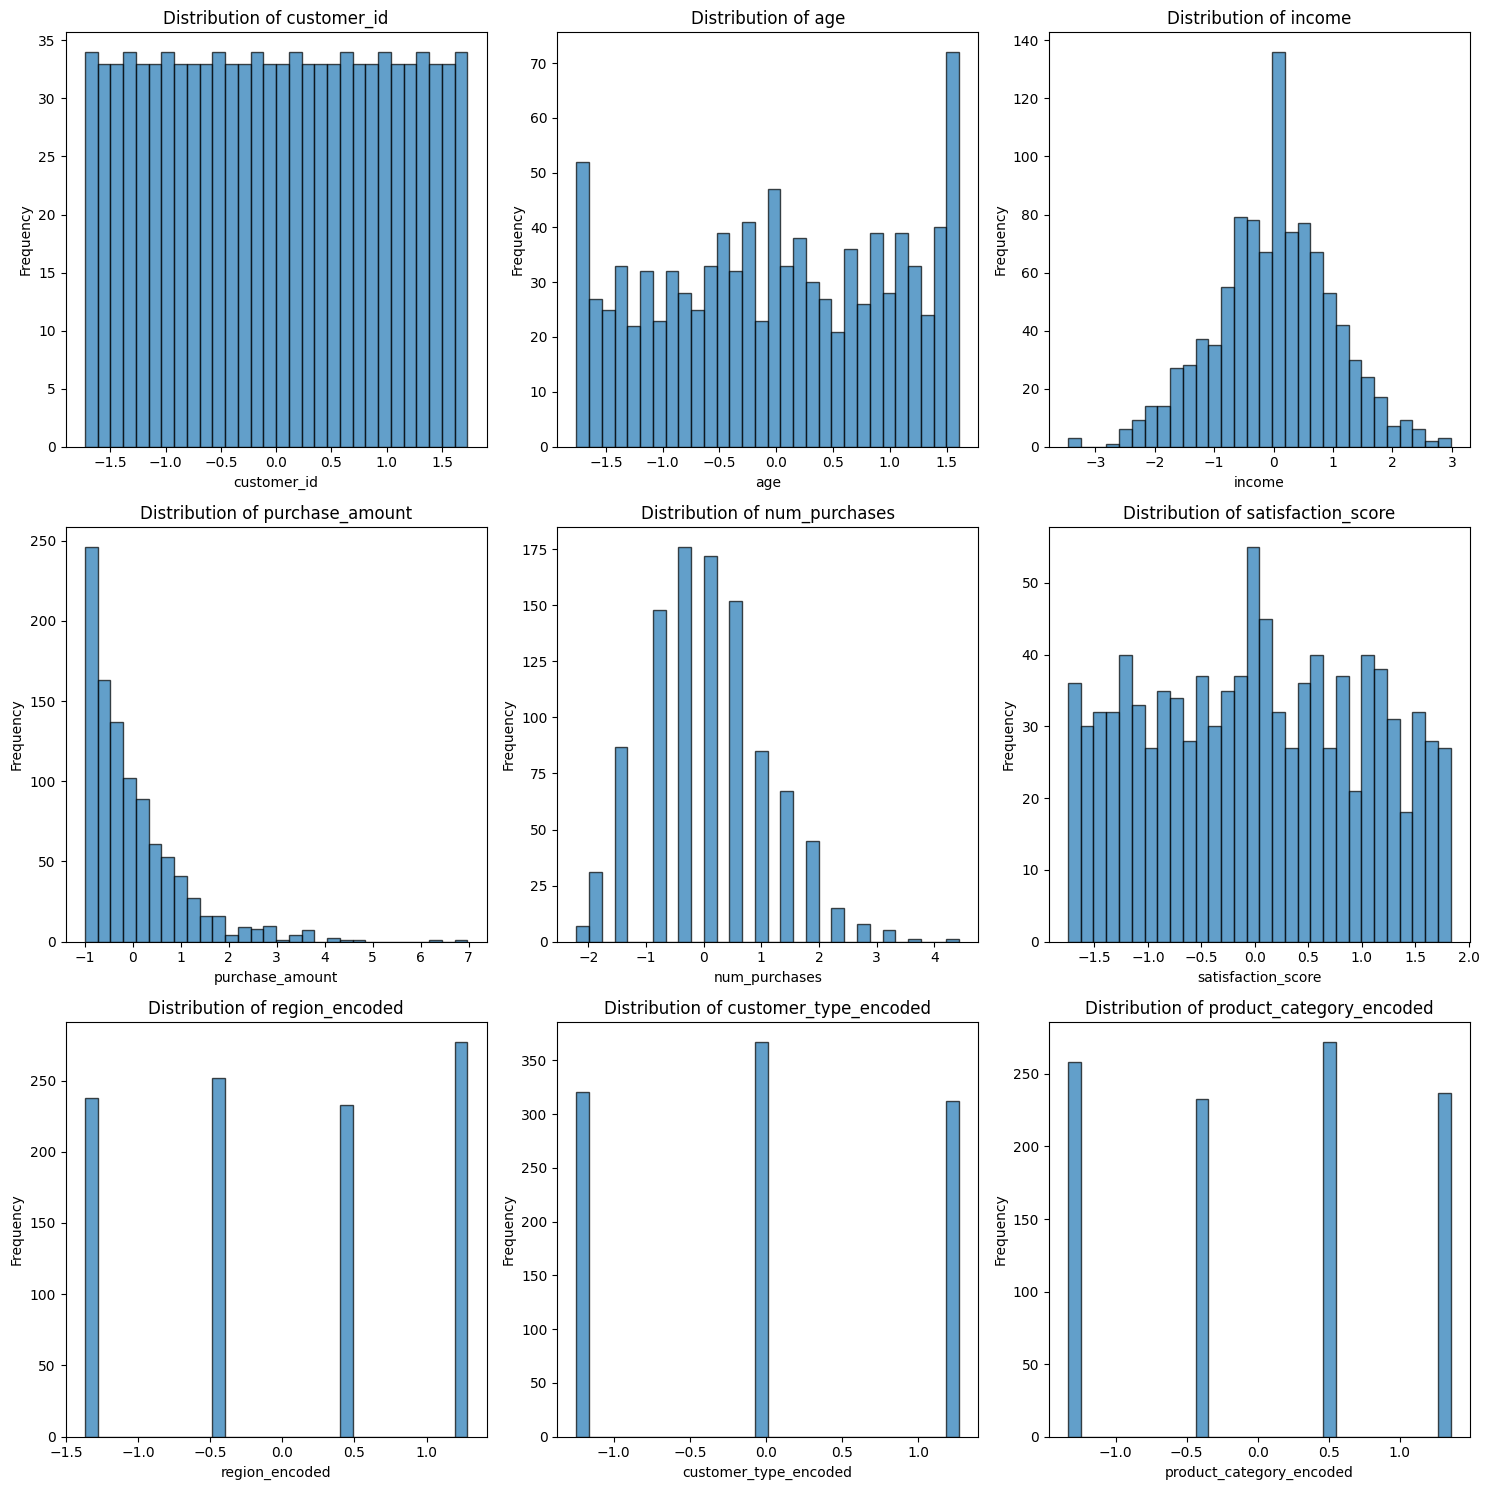

[LLM Orchestrator] ✓ plot_distributions completed successfully
[LLM Orchestrator] 
>>> Executing: exploration.plot_boxplots
[Data Exploration] Plotting box plots...


[LLM Orchestrator] ✓ plot_boxplots completed successfully
[LLM Orchestrator] 
>>> Executing: exploration.plot_countplots
[Data Exploration] Plotting count plots...


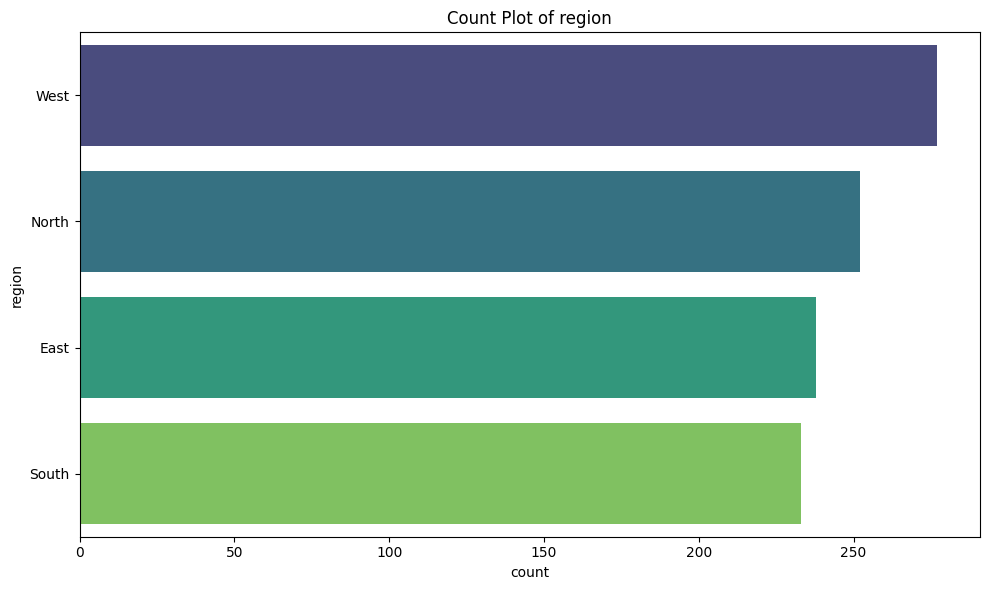

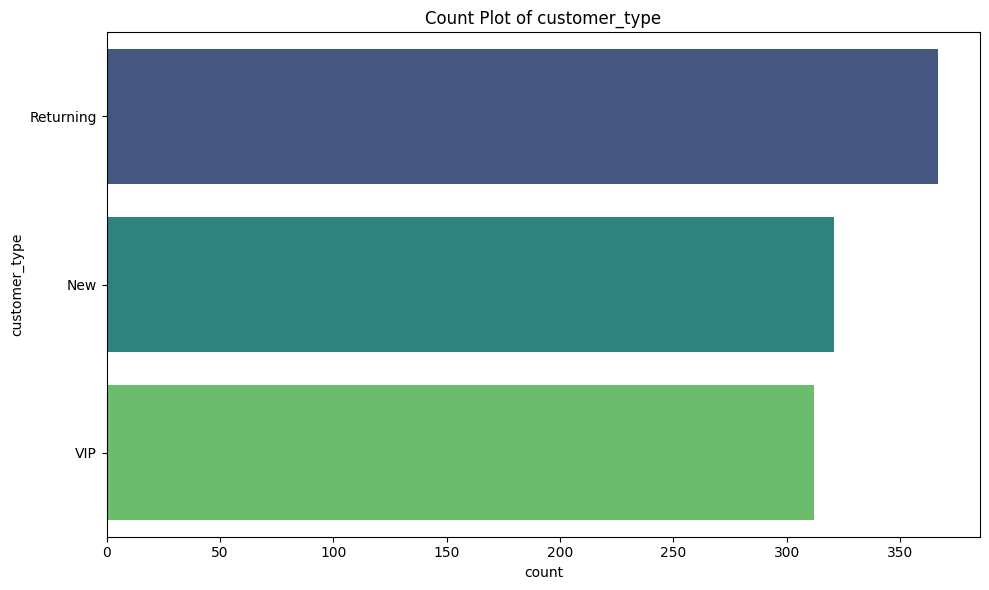

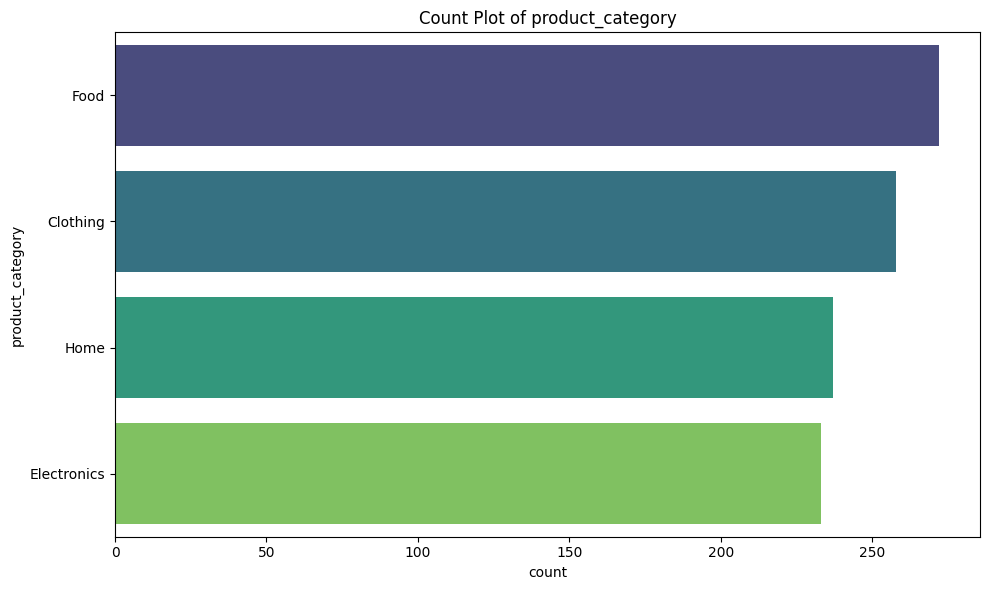

[LLM Orchestrator] ✓ plot_countplots completed successfully
[LLM Orchestrator] 
>>> Executing: exploration.perform_clustering
[Data Exploration] Performing K-means clustering...
[Data Exploration] Optimal number of clusters: 9


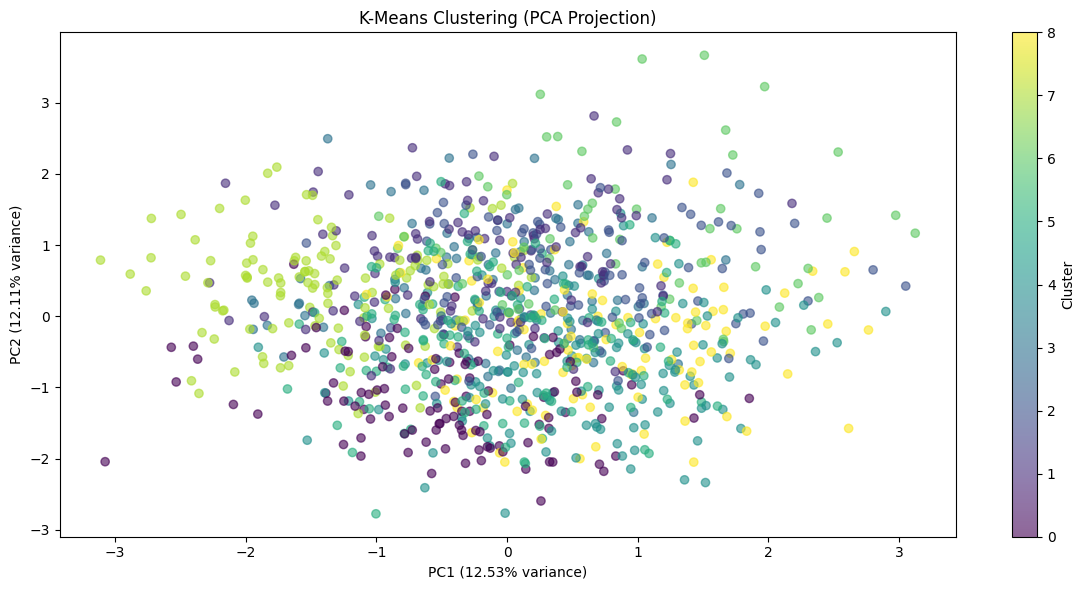

[LLM Orchestrator] ✓ perform_clustering completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.compute_correlations
[Relationship Discovery] Computing correlation matrices...
[Relationship Discovery] Plotting correlation heatmap...


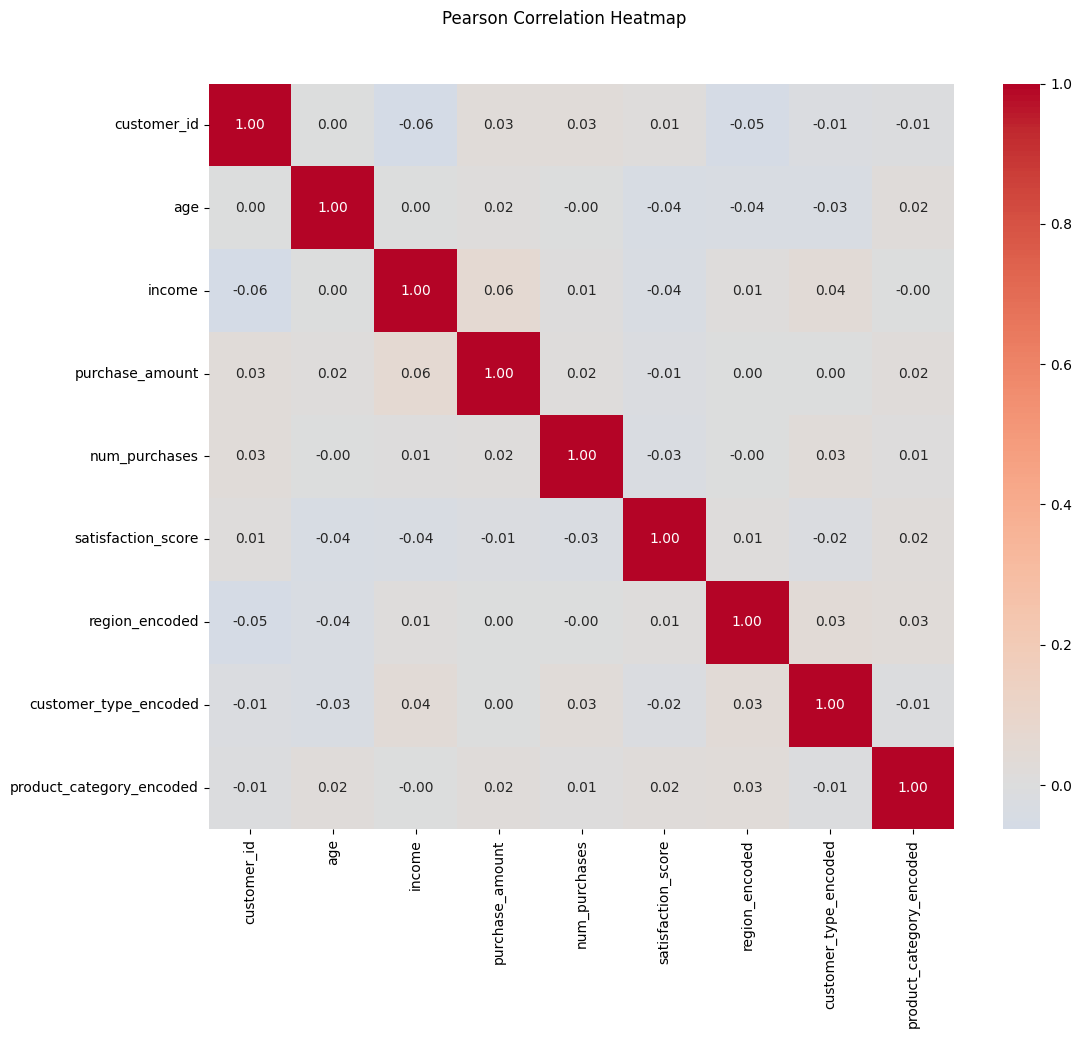

[Relationship Discovery] Plot 'Pearson Correlation Heatmap' generated
[Relationship Discovery] Correlation analysis complete
[LLM Orchestrator] ✓ compute_correlations completed successfully
[LLM Orchestrator] 
>>> Executing: exploration.create_scatter_matrix
[Data Exploration] Creating scatter matrix...


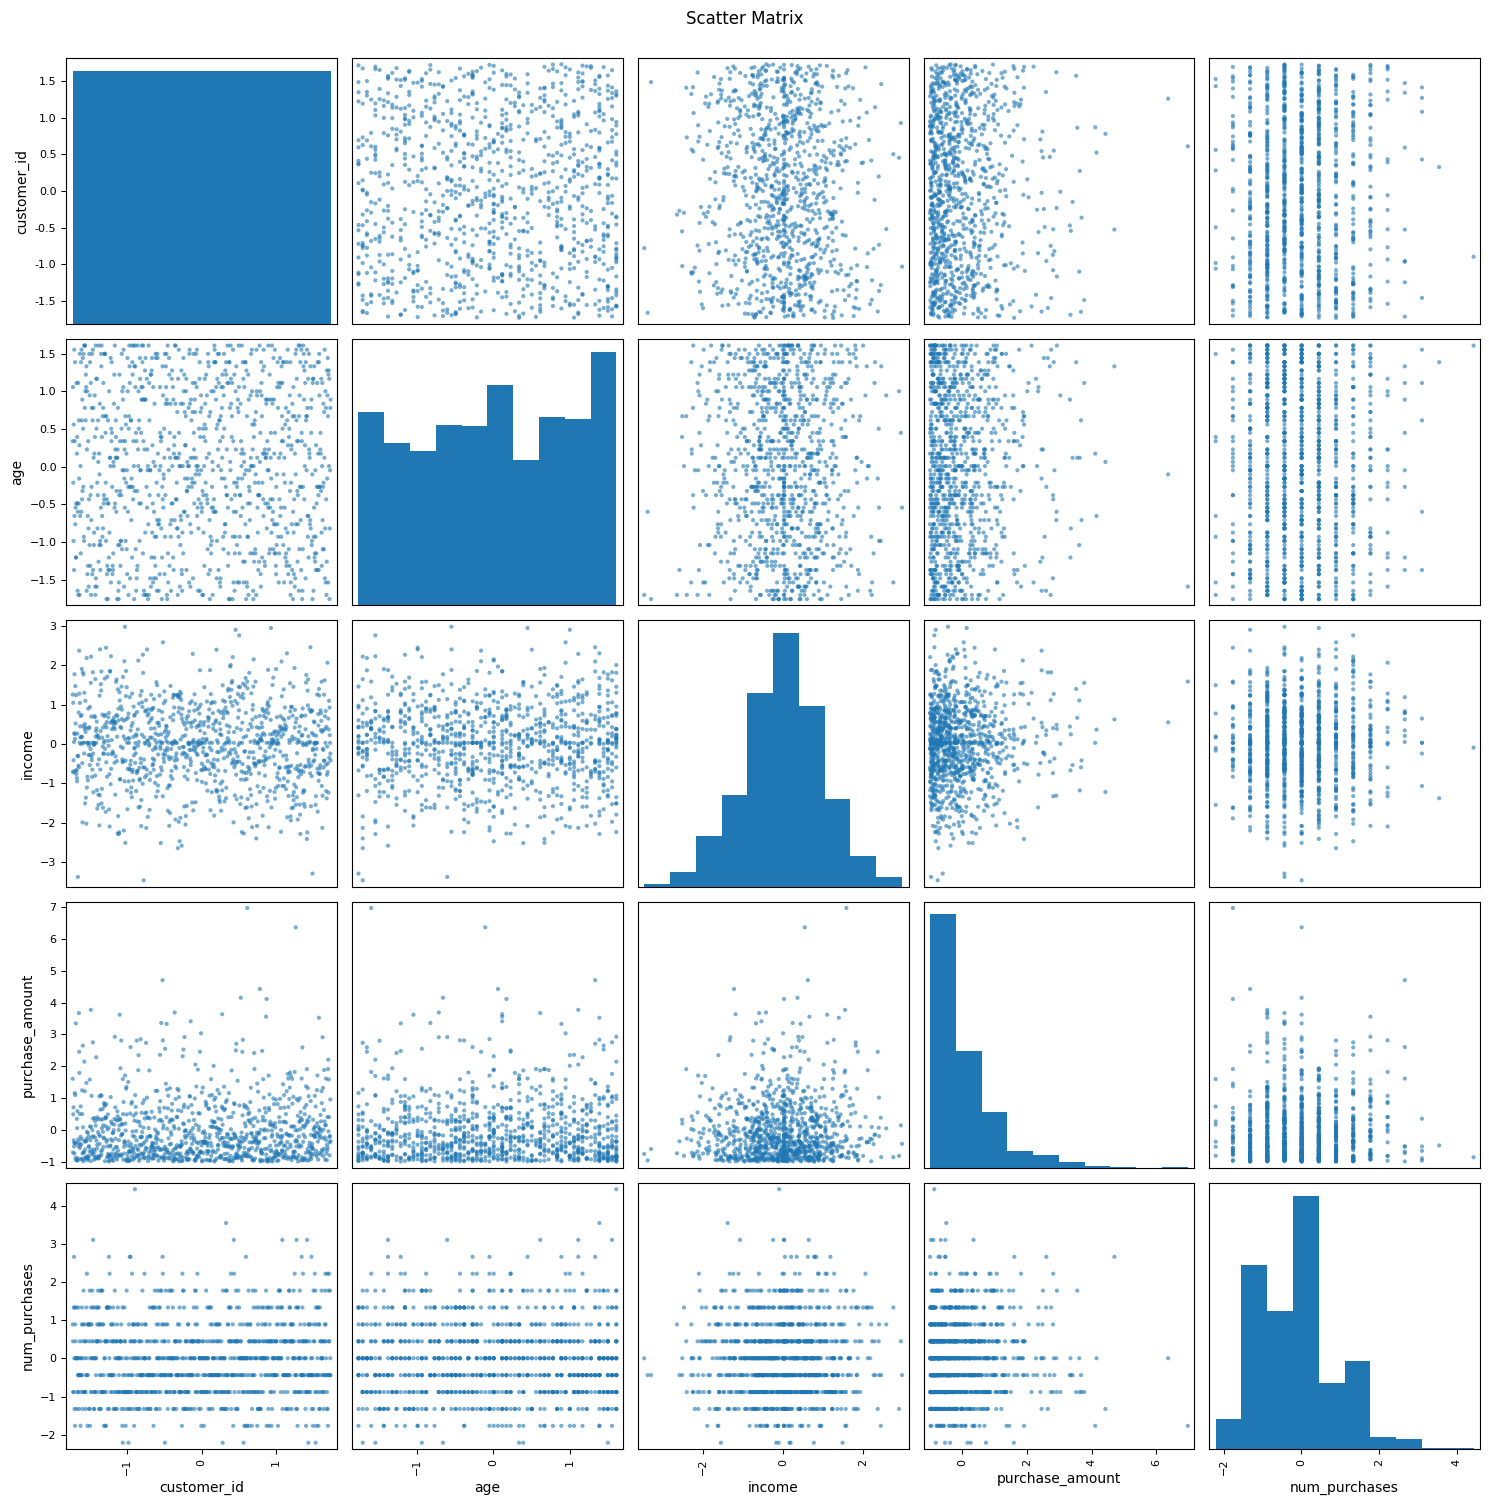

[LLM Orchestrator] ✓ create_scatter_matrix completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.plot_pairplot
[Relationship Discovery] Plotting pairplot...


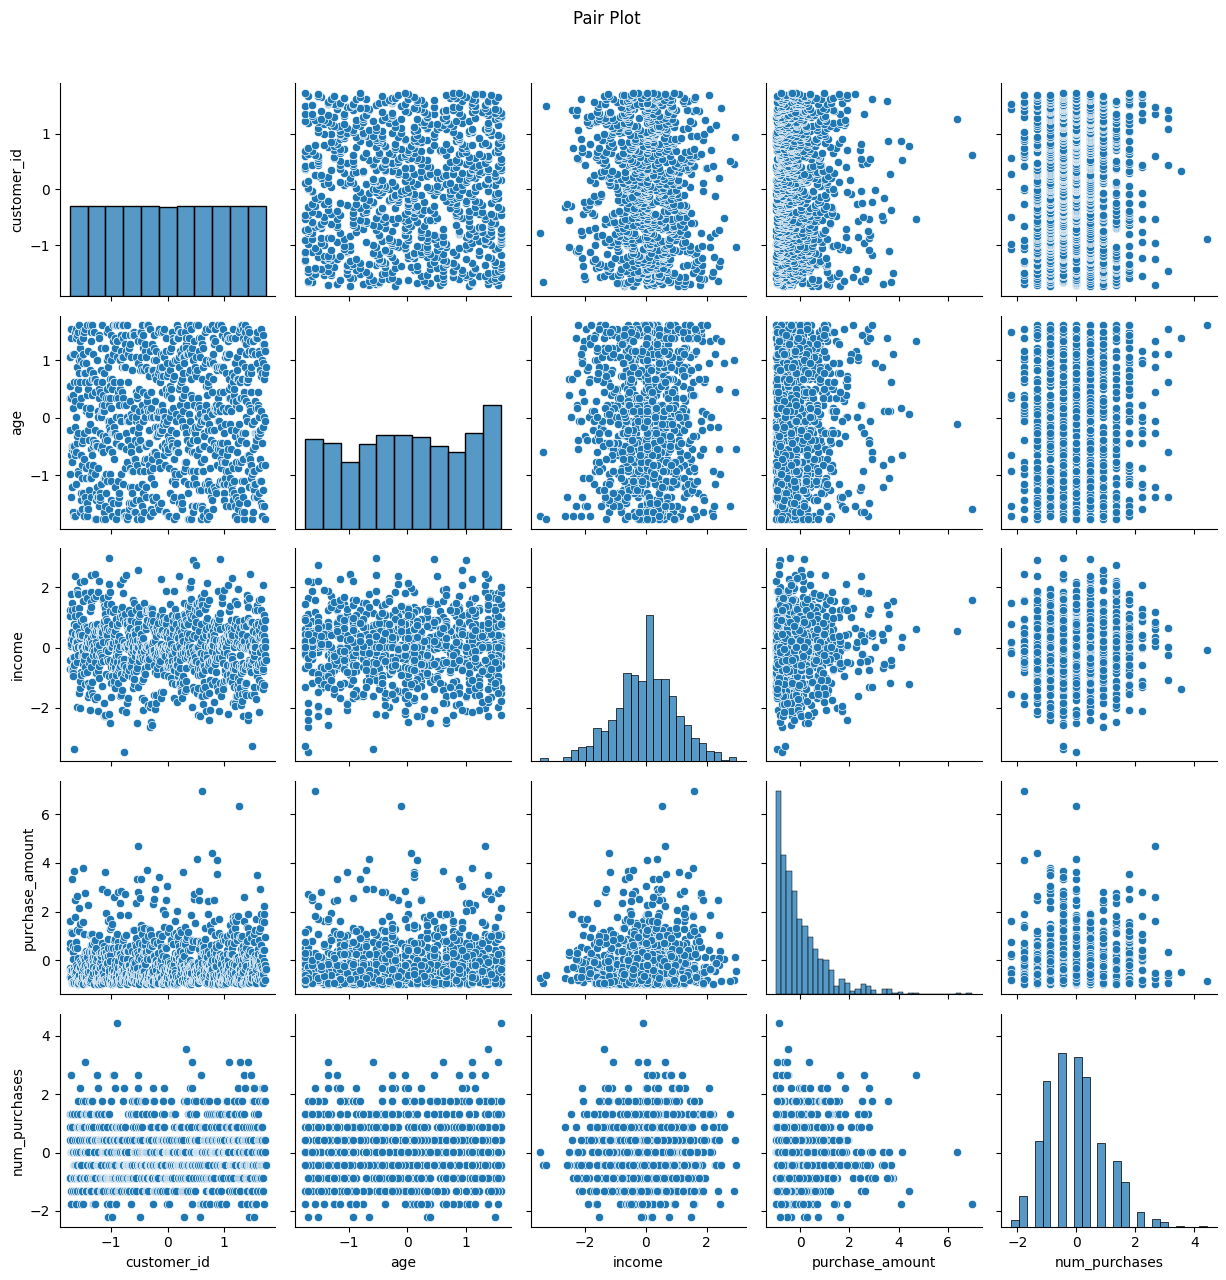

[Relationship Discovery] Plot 'Pair Plot' generated
[LLM Orchestrator] ✓ plot_pairplot completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.plot_boxplots_categorical_vs_numerical
[Relationship Discovery] Plotting box plots for categorical vs numerical...


[Relationship Discovery] Box plots for categorical vs numerical generated
[LLM Orchestrator] ✓ plot_boxplots_categorical_vs_numerical completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.identify_strong_relationships
[Relationship Discovery] Identifying relationships above threshold 0.5...
[Relationship Discovery] Found 0 strong relationships
[LLM Orchestrator] ✓ identify_strong_relationships completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.perform_regression_analysis
[Relationship Discovery] Performing regression analysis...


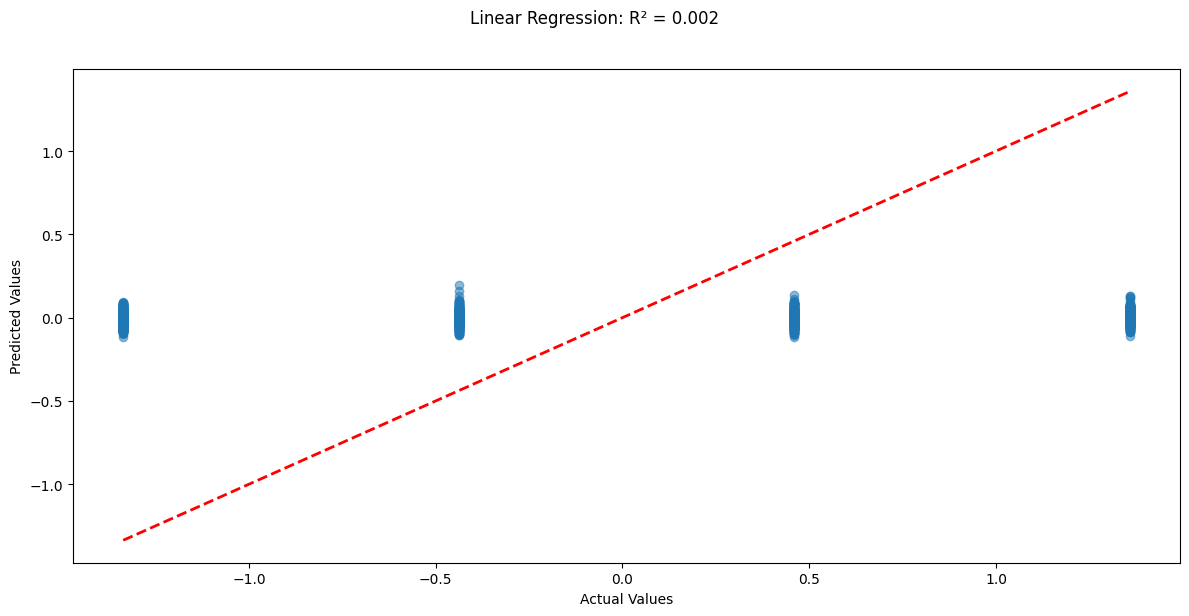

[Relationship Discovery] Plot 'Linear Regression: R² = 0.002' generated
[LLM Orchestrator] ✓ perform_regression_analysis completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.compute_mutual_information
[Relationship Discovery] Computing mutual information...


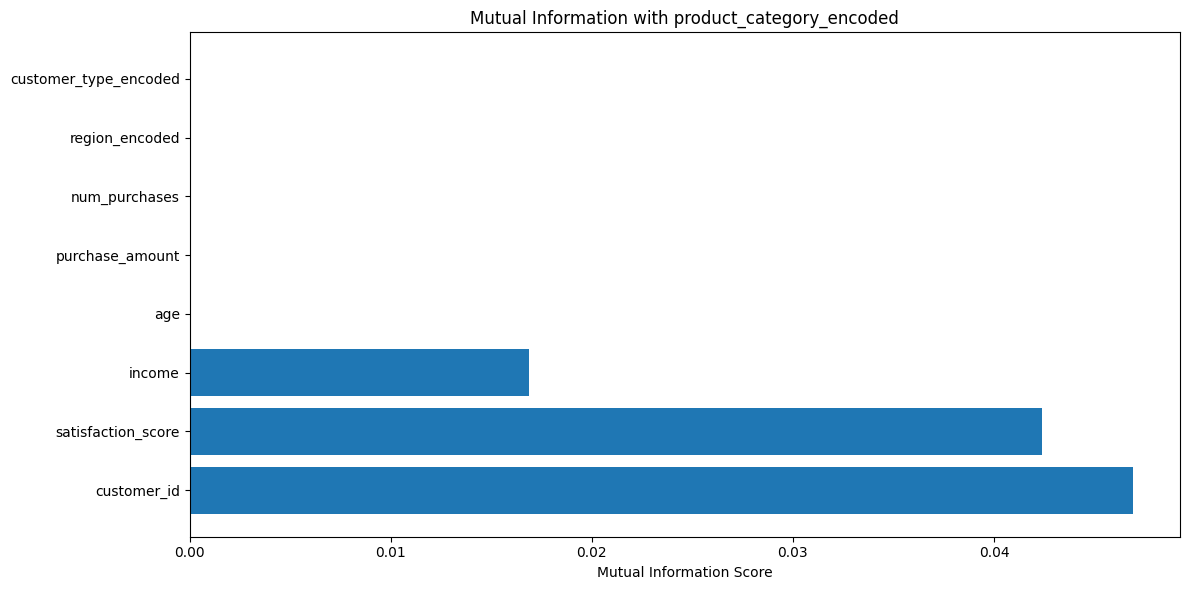

[Relationship Discovery] Mutual information computed for 8 features
[LLM Orchestrator] ✓ compute_mutual_information completed successfully
[LLM Orchestrator] 
>>> Executing: storytelling.generate_narrative_summary
[Data Storytelling] Generating narrative summary...
[Data Storytelling] Narrative summary generated
[LLM Orchestrator] ✓ generate_narrative_summary completed successfully
[LLM Orchestrator] 
>>> Executing: storytelling.create_summary_report
[Data Storytelling] Creating summary report...
[LLM Orchestrator] ✓ create_summary_report completed successfully
[LLM Orchestrator] 
>>> Executing: storytelling.create_interactive_dashboard
[Data Storytelling] Creating interactive dashboard...
[Data Storytelling] Dashboard created successfully
[LLM Orchestrator] ✓ create_interactive_dashboard completed successfully
[LLM Orchestrator] 
[LLM Orchestrator] WORKFLOW EXECUTION COMPLETE
[LLM Orchestrator] Steps completed: 22
[LLM Orchestrator] Steps failed: 0
[LLM Orchestrator] =================

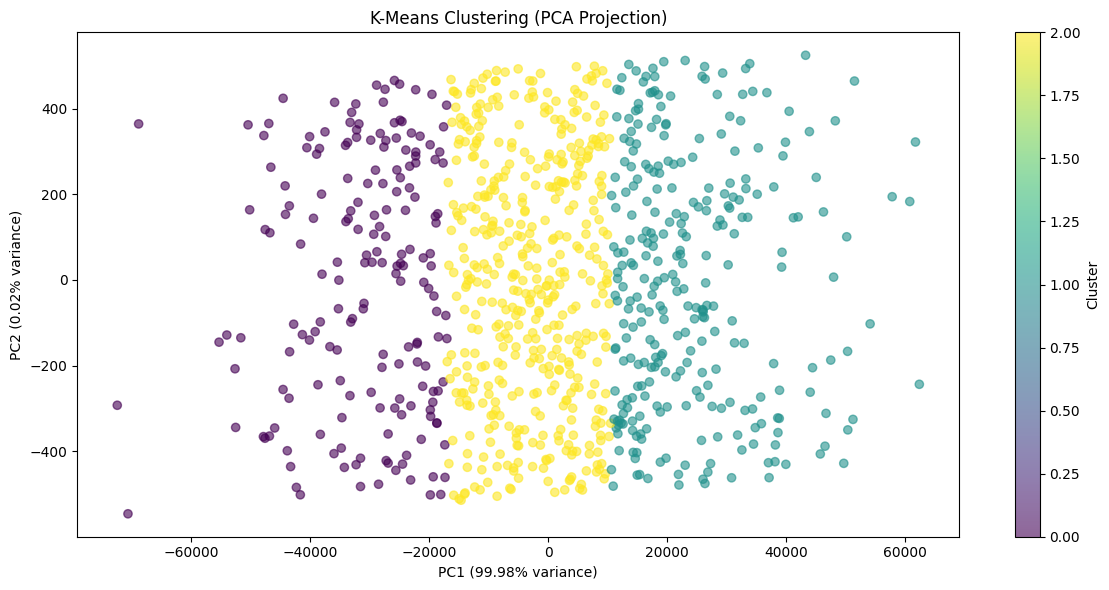

✓ PASSED

Test 8: Regression Analysis...
[Relationship Discovery] Performing regression analysis...


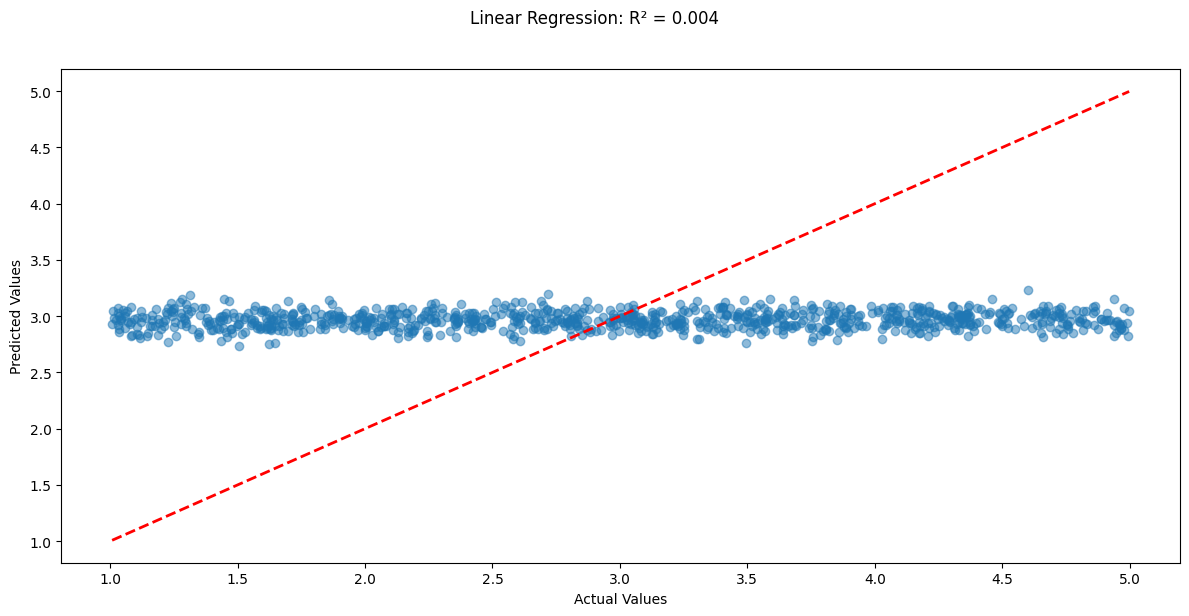

[Relationship Discovery] Plot 'Linear Regression: R² = 0.004' generated
✓ PASSED

Test 9: Narrative Generation...
[Data Storytelling] Generating summary insights...
[Data Storytelling] Generating narrative summary...
[Data Storytelling] Narrative summary generated
✓ PASSED

Test 10: End-to-End Workflow...
📂 Loading data...
✓ Data loaded: 1000 rows, 9 columns
[LLM Orchestrator] Initializing specialized agents...
[LLM Orchestrator] Initialized 5 agents
[LLM Orchestrator] Creating workflow plan...
[LLM Orchestrator] Analyzing dataset requirements...
[LLM Orchestrator] Using rule-based workflow with 22 steps (LLM planning temporarily bypassed due to method naming issues)
[LLM Orchestrator] ============================================================
[LLM Orchestrator] EXECUTING MULTI-AGENT EDA WORKFLOW
[LLM Orchestrator] ============================================================
[LLM Orchestrator] 
>>> Executing: quality.assess_data_quality
[Data Quality] Assessing data quality...
[Data 

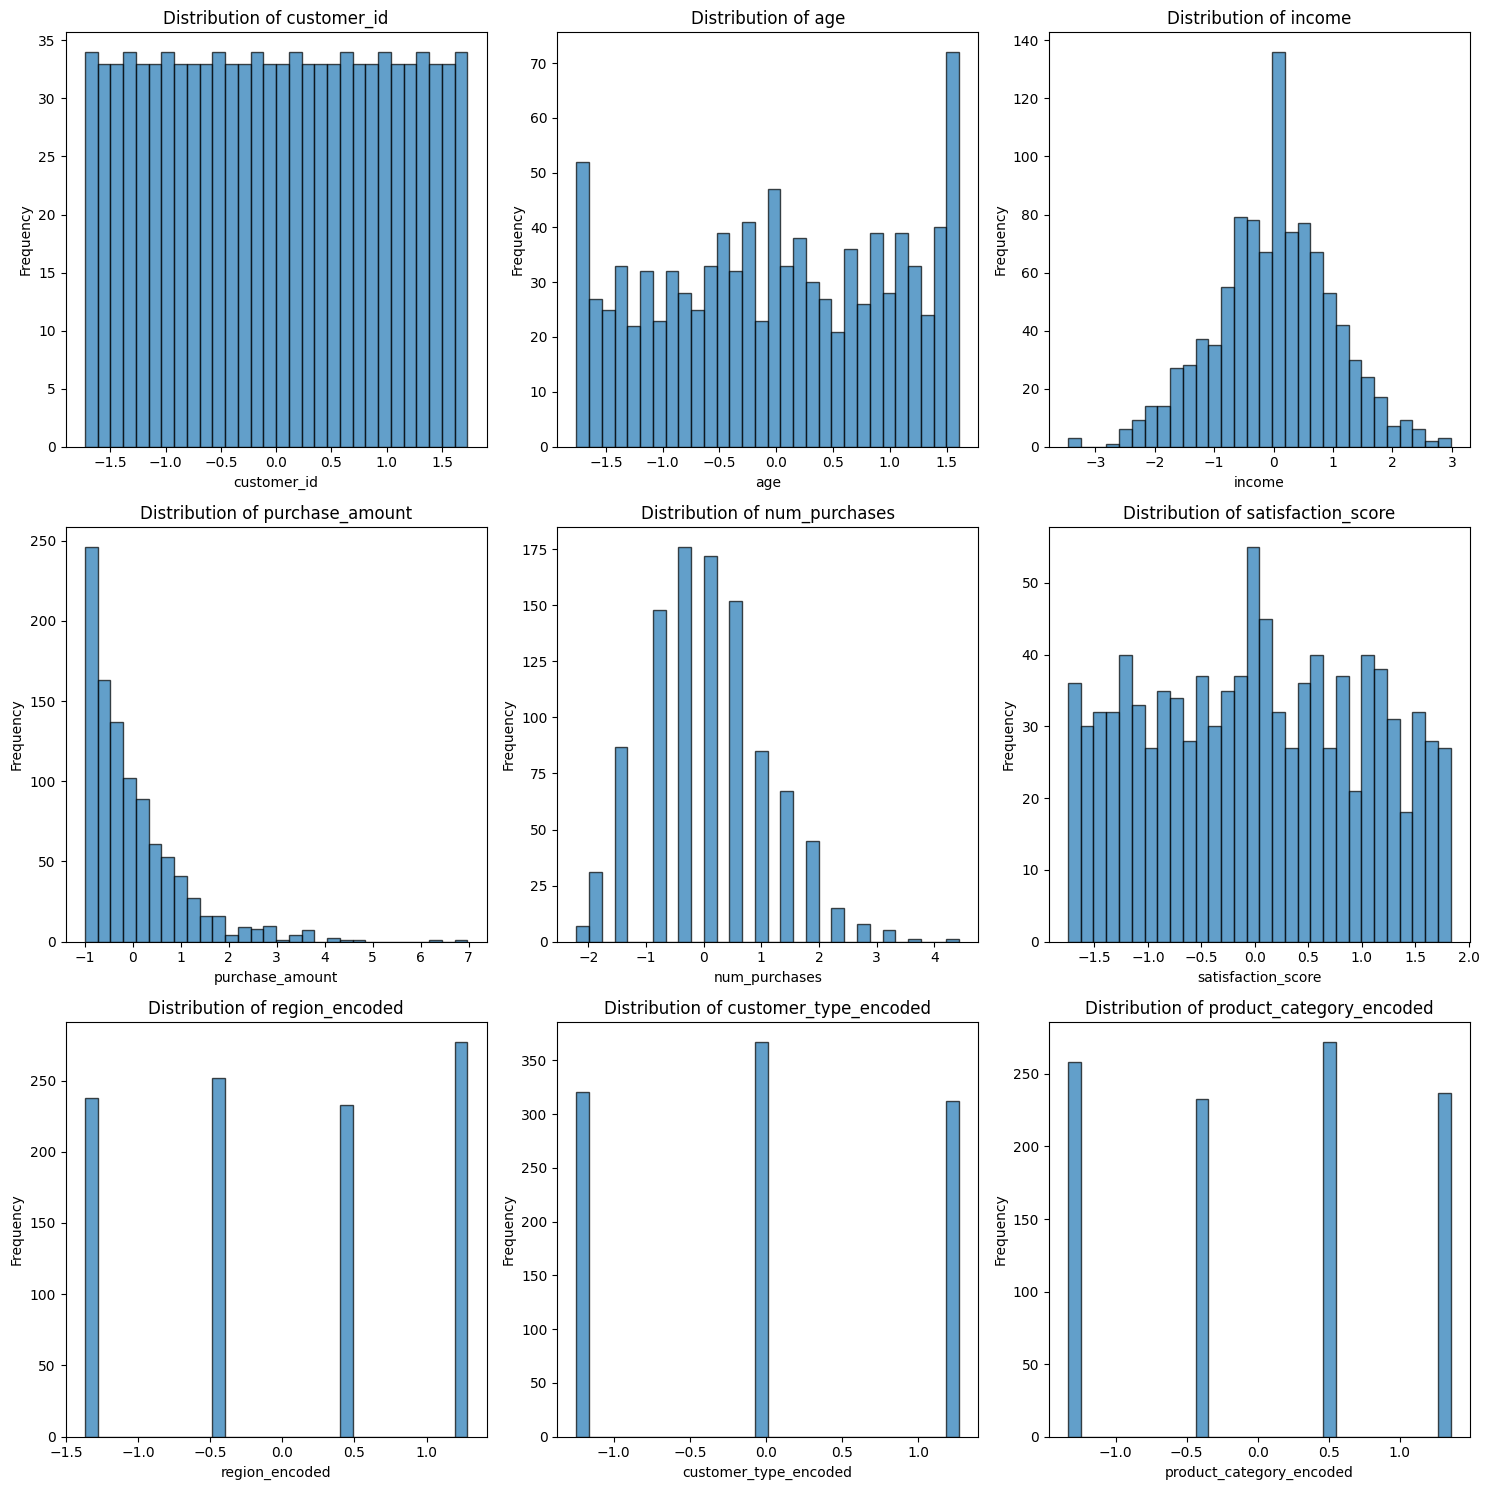

[LLM Orchestrator] ✓ plot_distributions completed successfully
[LLM Orchestrator] 
>>> Executing: exploration.plot_boxplots
[Data Exploration] Plotting box plots...


[LLM Orchestrator] ✓ plot_boxplots completed successfully
[LLM Orchestrator] 
>>> Executing: exploration.plot_countplots
[Data Exploration] Plotting count plots...


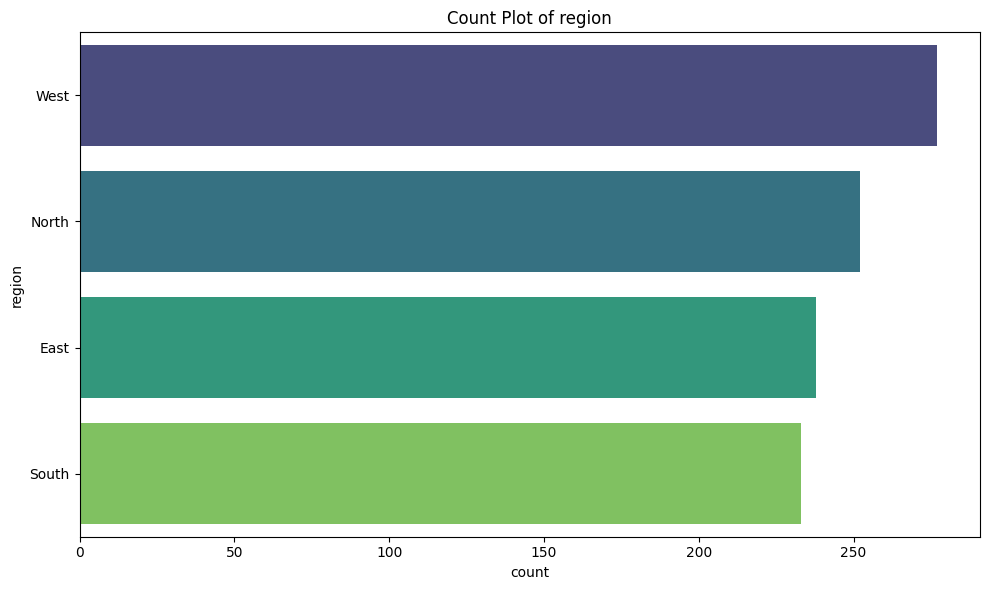

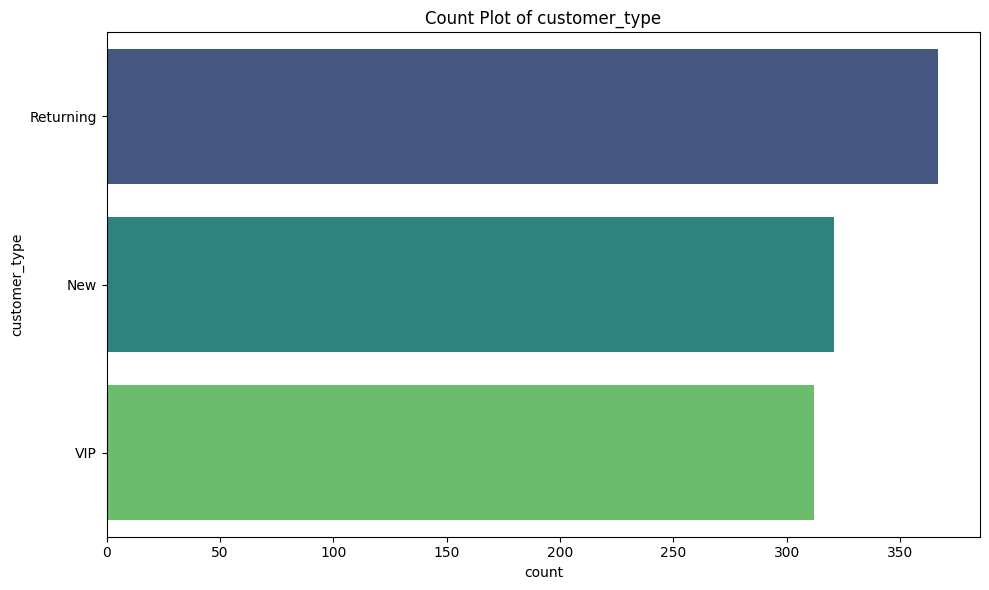

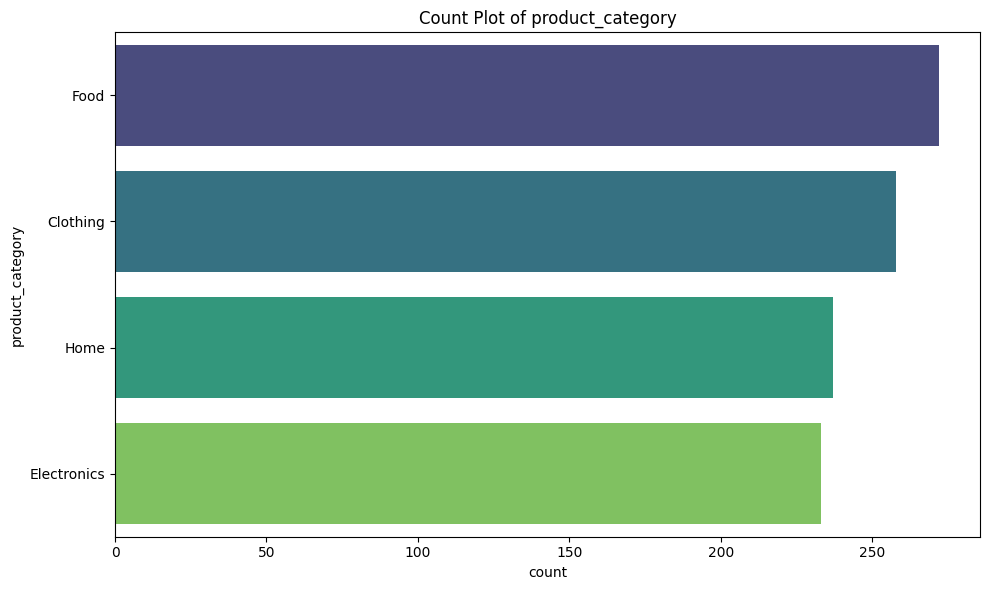

[LLM Orchestrator] ✓ plot_countplots completed successfully
[LLM Orchestrator] 
>>> Executing: exploration.perform_clustering
[Data Exploration] Performing K-means clustering...
[Data Exploration] Optimal number of clusters: 9


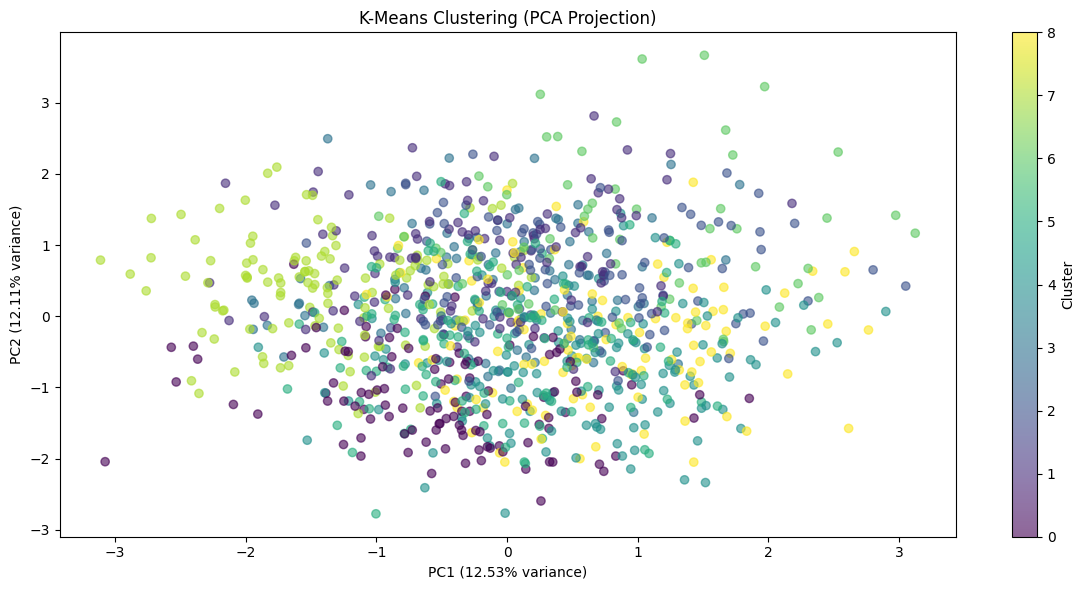

[LLM Orchestrator] ✓ perform_clustering completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.compute_correlations
[Relationship Discovery] Computing correlation matrices...
[Relationship Discovery] Plotting correlation heatmap...


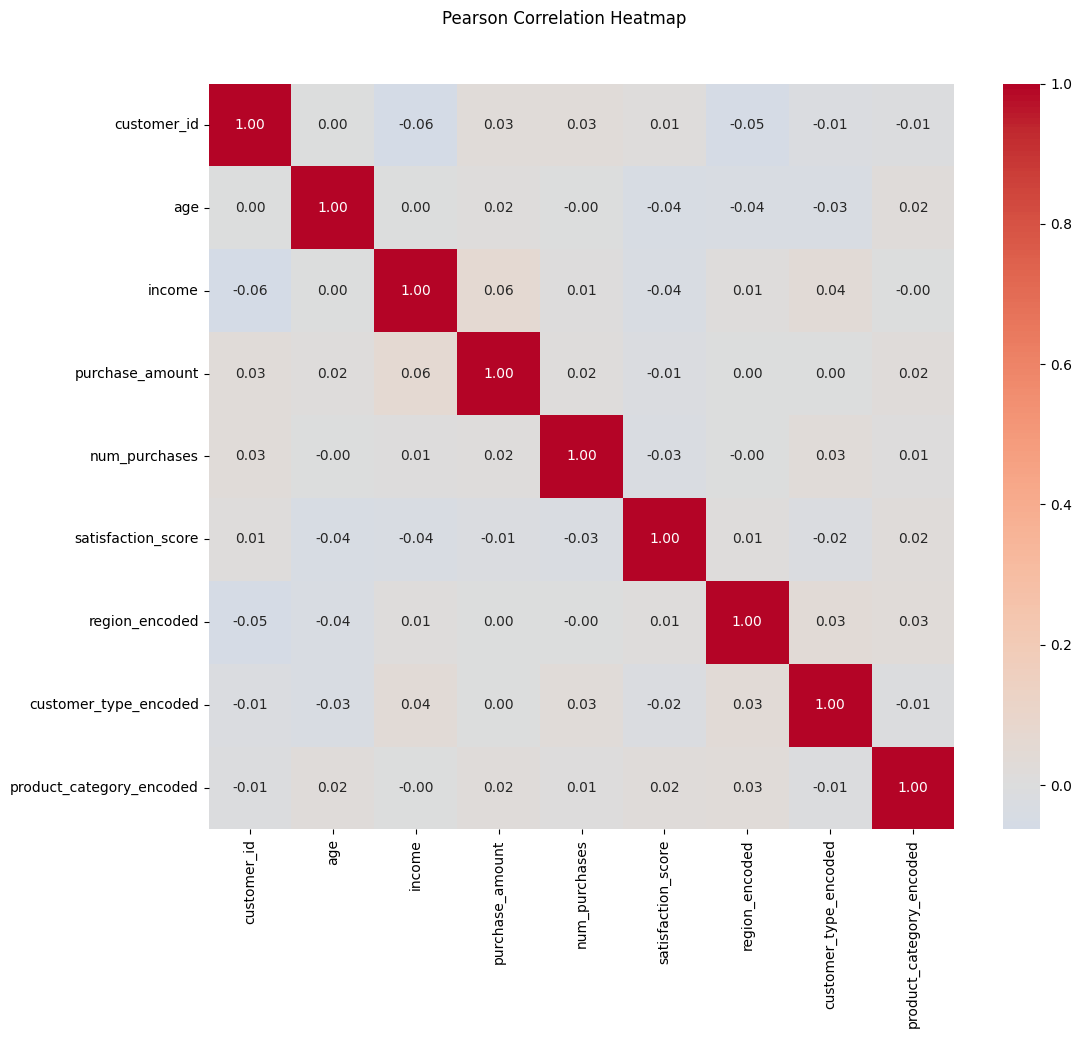

[Relationship Discovery] Plot 'Pearson Correlation Heatmap' generated
[Relationship Discovery] Correlation analysis complete
[LLM Orchestrator] ✓ compute_correlations completed successfully
[LLM Orchestrator] 
>>> Executing: exploration.create_scatter_matrix
[Data Exploration] Creating scatter matrix...


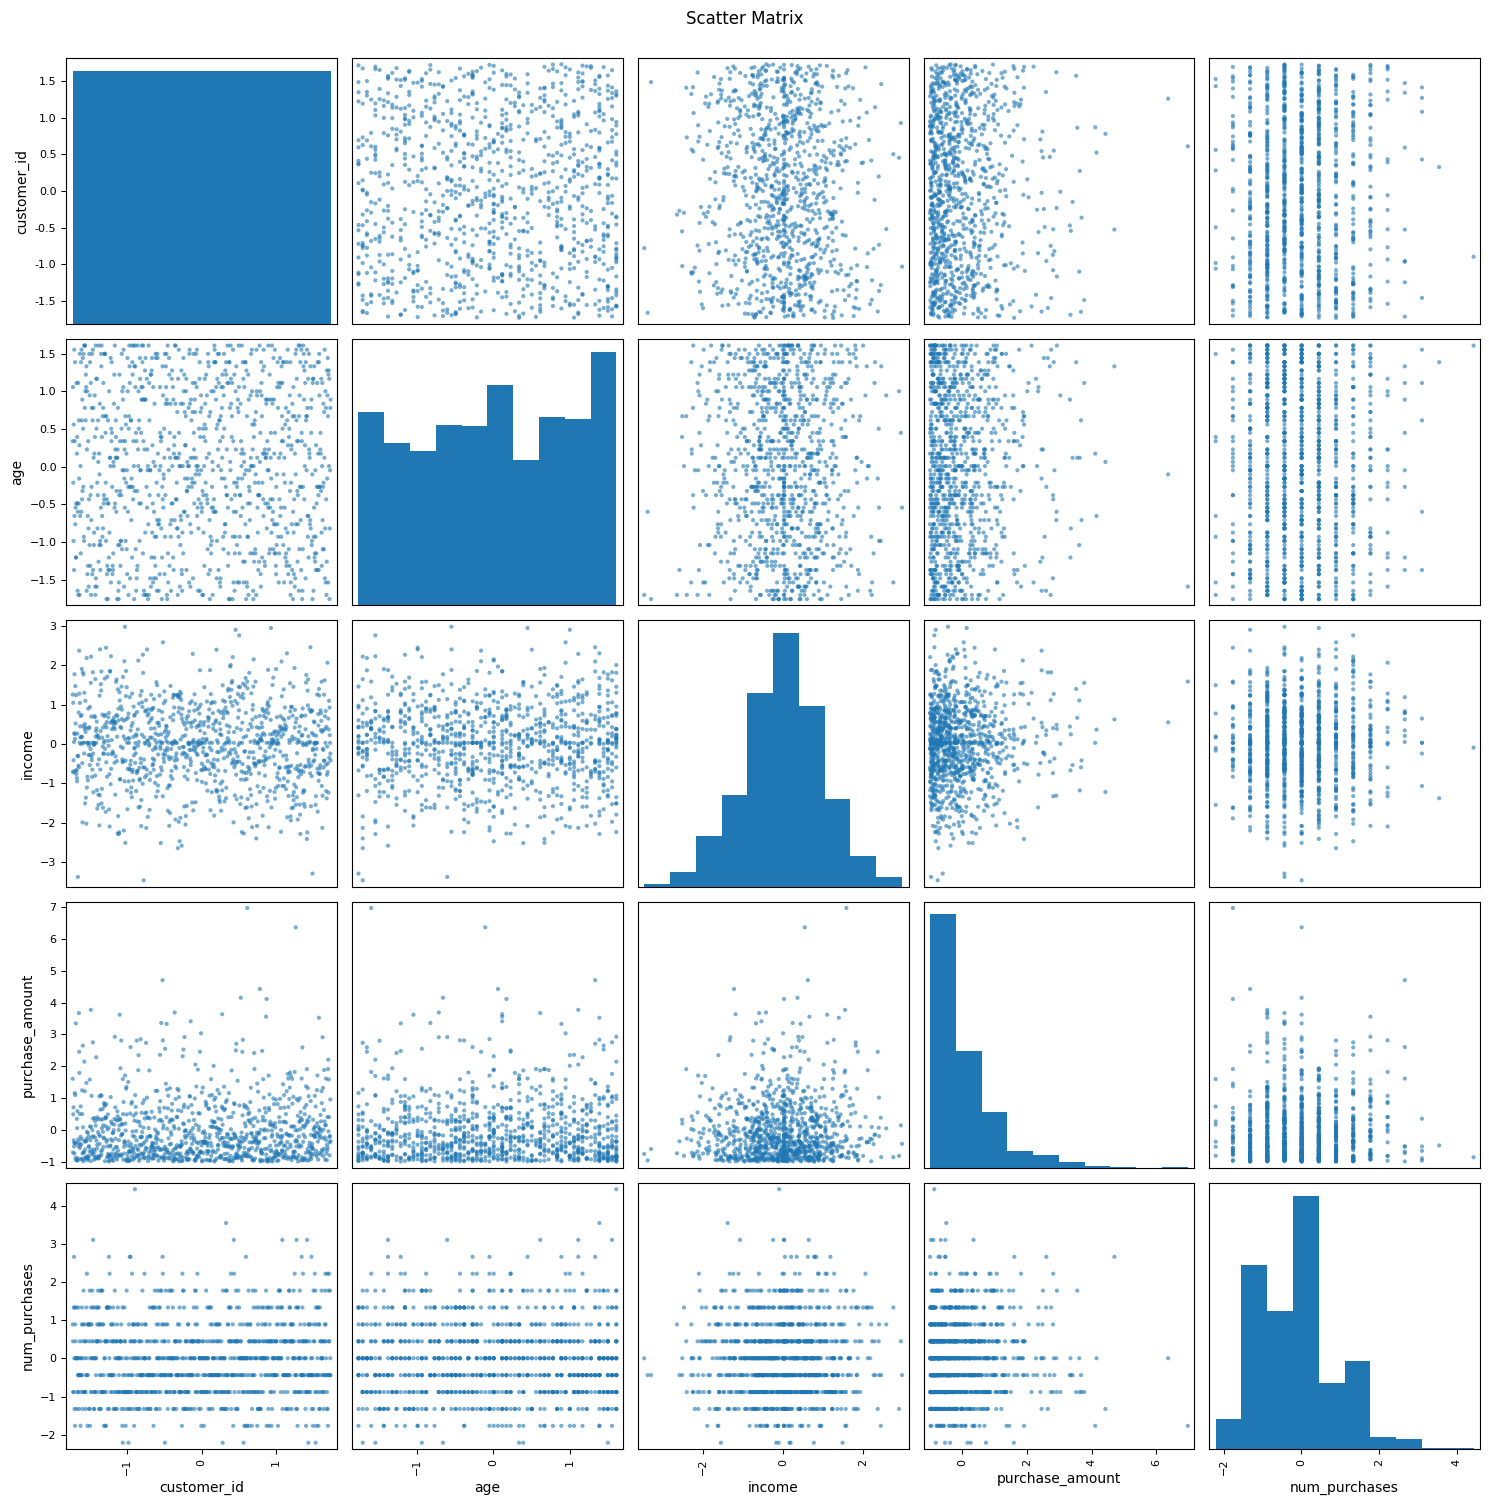

[LLM Orchestrator] ✓ create_scatter_matrix completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.plot_pairplot
[Relationship Discovery] Plotting pairplot...


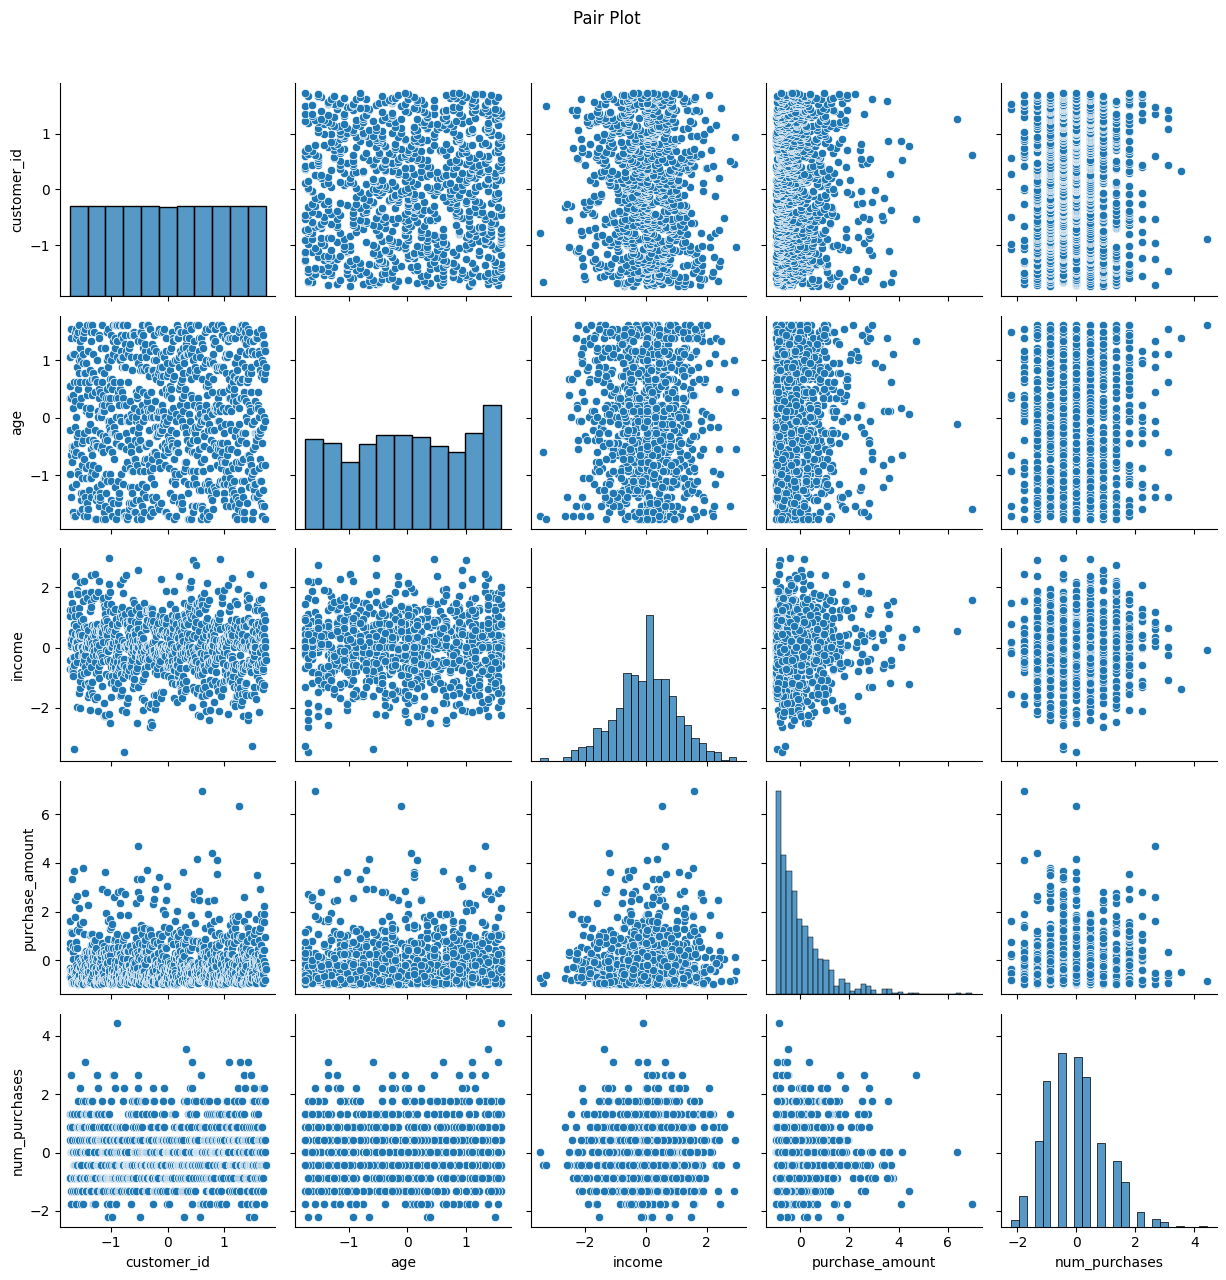

[Relationship Discovery] Plot 'Pair Plot' generated
[LLM Orchestrator] ✓ plot_pairplot completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.plot_boxplots_categorical_vs_numerical
[Relationship Discovery] Plotting box plots for categorical vs numerical...


[Relationship Discovery] Box plots for categorical vs numerical generated
[LLM Orchestrator] ✓ plot_boxplots_categorical_vs_numerical completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.identify_strong_relationships
[Relationship Discovery] Identifying relationships above threshold 0.5...
[Relationship Discovery] Found 0 strong relationships
[LLM Orchestrator] ✓ identify_strong_relationships completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.perform_regression_analysis
[Relationship Discovery] Performing regression analysis...


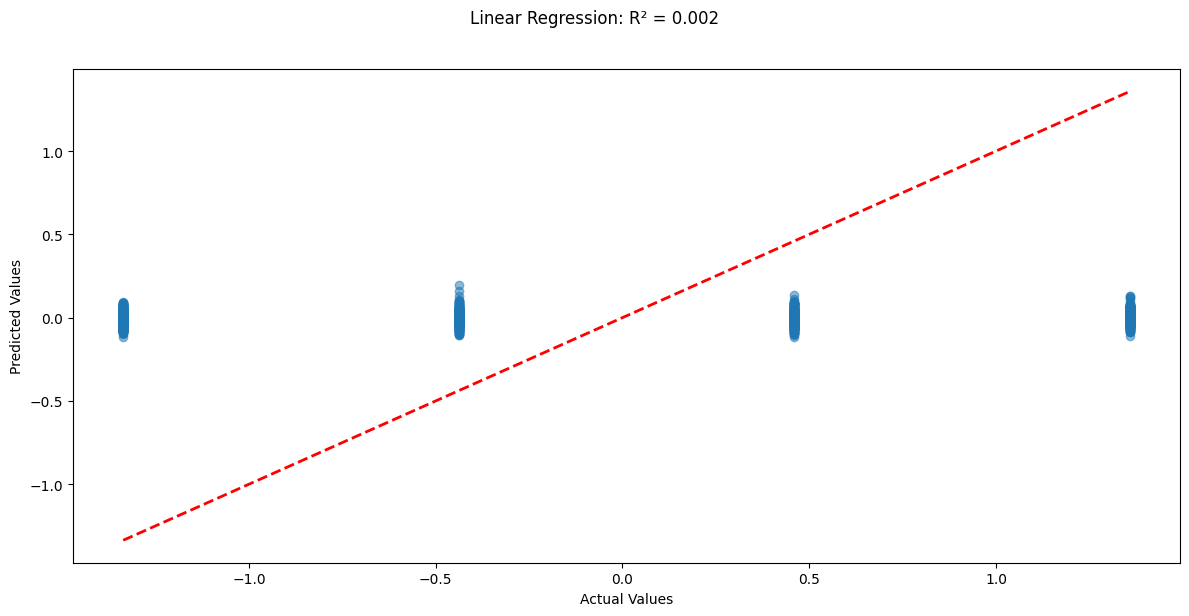

[Relationship Discovery] Plot 'Linear Regression: R² = 0.002' generated
[LLM Orchestrator] ✓ perform_regression_analysis completed successfully
[LLM Orchestrator] 
>>> Executing: relationships.compute_mutual_information
[Relationship Discovery] Computing mutual information...


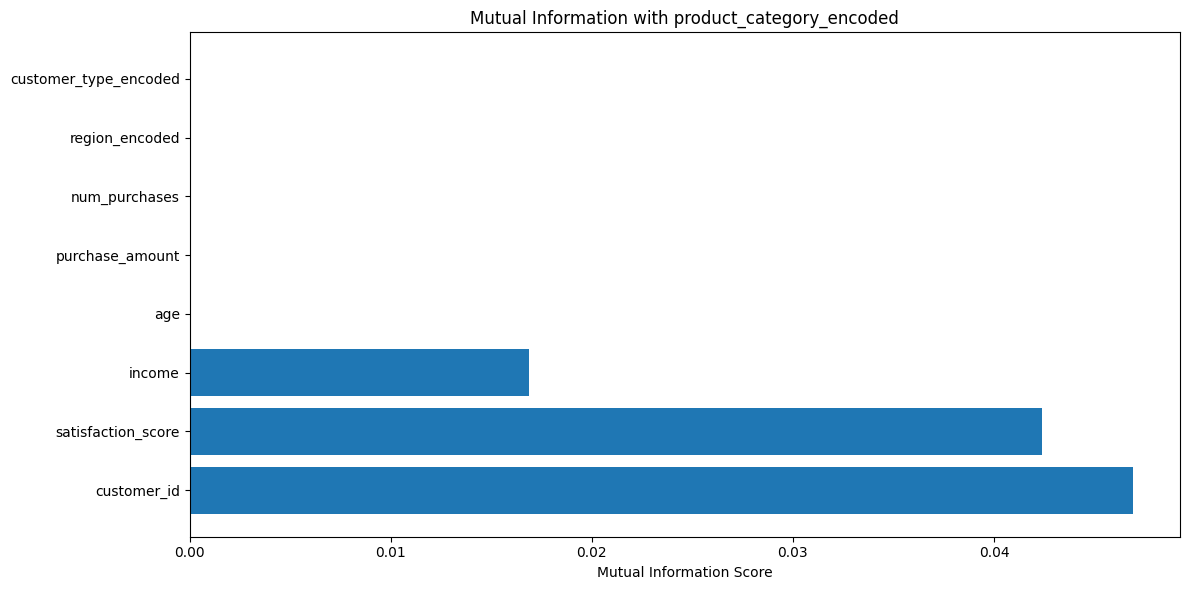

[Relationship Discovery] Mutual information computed for 8 features
[LLM Orchestrator] ✓ compute_mutual_information completed successfully
[LLM Orchestrator] 
>>> Executing: storytelling.generate_narrative_summary
[Data Storytelling] Generating narrative summary...
[Data Storytelling] Narrative summary generated
[LLM Orchestrator] ✓ generate_narrative_summary completed successfully
[LLM Orchestrator] 
>>> Executing: storytelling.create_summary_report
[Data Storytelling] Creating summary report...
[LLM Orchestrator] ✓ create_summary_report completed successfully
[LLM Orchestrator] 
>>> Executing: storytelling.create_interactive_dashboard
[Data Storytelling] Creating interactive dashboard...
[Data Storytelling] Dashboard created successfully
[LLM Orchestrator] ✓ create_interactive_dashboard completed successfully
[LLM Orchestrator] 
[LLM Orchestrator] WORKFLOW EXECUTION COMPLETE
[LLM Orchestrator] Steps completed: 22
[LLM Orchestrator] Steps failed: 0
[LLM Orchestrator] =================

In [20]:
# CELL 14: Usage Example
# =============================================================================

if __name__ == "__main__":
    # Create sample dataset
    np.random.seed(42)
    sample_data = pd.DataFrame({
        'customer_id': range(1, 1001),
        'age': np.random.randint(18, 80, 1000),
        'income': np.random.normal(50000, 20000, 1000),
        'purchase_amount': np.random.exponential(100, 1000),
        'num_purchases': np.random.poisson(5, 1000),
        'satisfaction_score': np.random.uniform(1, 5, 1000),
        'region': np.random.choice(['North', 'South', 'East', 'West'], 1000),
        'customer_type': np.random.choice(['New', 'Returning', 'VIP'], 1000),
        'product_category': np.random.choice(['Electronics', 'Clothing', 'Food', 'Home'], 1000)
    })

    # Add missing values
    sample_data.loc[sample_data.sample(50).index, 'income'] = np.nan
    sample_data.loc[sample_data.sample(30).index, 'satisfaction_score'] = np.nan

    print("✓ Sample dataset created")
    print(sample_data.head())

    # Run EDA
    print("\n" + "="*60)
    print("STARTING MULTI-AGENT EDA SYSTEM")
    print("="*60 + "\n")

    eda_system = MultiAgentEDASystem()
    results = eda_system.run_analysis(sample_data)

    print("\n✅ Analysis complete!")

    # ====================
    # VIEW DASHBOARD
    # ====================
    print("\n" + "="*60)
    print("DASHBOARD SETUP")
    print("="*60 + "\n")

    # Create dashboard
    if DASH_AVAILABLE:
        storytelling_agent = eda_system.orchestrator.agents['storytelling']
        dashboard = storytelling_agent.create_interactive_dashboard(
            eda_system.raw_data,
            results['agent_results']
        )

        if dashboard:
            print("🚀 Dashboard created successfully!")
            print(f"To view dashboard, run:")
            print(f"  dashboard.run_server(debug=True, port={Config.DASH_PORT})")
            print(f"\nOr in Jupyter/Colab:")
            print(f"  dashboard.run_server(mode='inline', port={Config.DASH_PORT})")

            # Uncomment to run dashboard immediately
            # dashboard.run_server(debug=True, port=Config.DASH_PORT)
    else:
        print("⚠️  Dash not available. Install dash and dash-bootstrap-components to enable dashboard.")

    # Generate HTML report as alternative
    print("\n📄 Generating HTML report...")
    html_report = eda_system.orchestrator.agents['storytelling'].create_summary_report(
        eda_system.raw_data,
        results['agent_results']
    )
    with open('eda_summary_report.html', 'w') as f:
        f.write(html_report)
    print("✓ HTML report saved to: eda_summary_report.html")

    # ====================
    # RUN TEST CASES
    # ====================
    test_results = run_test_cases(sample_data)

    # ====================
    # EVALUATION REPORT
    # ====================
    evaluation_report = generate_evaluation_report(results, test_results)

    # Save evaluation report
    with open('evaluation_report.txt', 'w') as f:
        f.write(evaluation_report)
    print("✓ Evaluation report saved to: evaluation_report.txt")

    # ====================
    # CLOUD DEPLOYMENT
    # ====================
    print("\n" + "="*60)
    print("CLOUD RUN DEPLOYMENT SETUP")
    print("="*60 + "\n")

    generate_choice = input("Generate Cloud Run deployment files? (yes/no): ").lower()
    if generate_choice == 'yes':
        generate_deployment_files()
    else:
        print("Skipping deployment file generation.")

    # Export results
    eda_system.export_results('eda_results.json')

    print("\n" + "="*60)
    print("ALL PROCESSES COMPLETED SUCCESSFULLY")
    print("="*60)
    print("\nGenerated Files:")
    print("  1. eda_results.json - Complete analysis results")
    print("  2. eda_summary_report.html - Visual HTML report")
    print("  3. evaluation_report.txt - Performance metrics")
    if generate_choice == 'yes':
        print("  4. Deployment files (app.py, Dockerfile, etc.)")
    print("\n" + "="*60)

In [ ]:
with open('DEPLOYMENT_GUIDE.md', 'r') as f:
    guide_content = f.read()
print(guide_content)